## Bnb for R-only case, with outliers

- One way to deal with outliers is to set a very small delta (test 1), but this takes very long to run
- Another way to deal with outliers is to limit the e_max (tests 2 & 3), if a noise ratio is roughly known
   - E.g. If expected number of inliers is 30 out of 35 pairs, e_max will stop increasing at 30. 

### 1. Very small delta (1/64 * pi)

In [12]:
from Stereo import * 

N = 30
s = Stereo(n = N)

# Set up two views of 30 points with rotation only
# s.transformCamera(x=a, y=b, z=c, roll=r, pitch=p, yaw=y)
rpy = (0.2,-0.1,0.1)

pts1 = s.transformCamera(False, 0,0,0,0,0,0)
pts2 = s.transformCamera(False, 0,0,0,*rpy)

# Outliers
n_out = 5
pts1 = np.concatenate((pts1, np.random.uniform(-1, 1, (n_out,2))), axis = 0)
pts2 = np.concatenate((pts2, np.random.uniform(-1, 1, (n_out,2))), axis = 0)

# Increase N to include outlier count
N += n_out

In [3]:
from bnb import * 
from math import pi, sqrt

%matplotlib inline
import matplotlib.pyplot as plt

import time 
start = time.time()

# Set up pts1 and pts2 as 3d vectors
pts2_ones = np.ones((N,3))
pts2_ones[:,:-1] = pts2
pts1_ones = np.ones((N,3))
pts1_ones[:,:-1] = pts1

# Prepare capacity matrix (parts common to all cases)
n_C = 1+N+N+1 
C = np.zeros((n_C, n_C))
C[0        , 1:N+1] = 1
C[N+1:N+N+1,    -1] = 1

e_max = 0
delta = 1/64 * pi 
centres, sigma = subdivide(0, 0, 0, pi)

# Process blocks and subblocks in a queue
i = 0
queue = []
for c in centres: 
    queue.append((c[None, :], sigma, N))

# Store solutions
solutions = []

# For each block, given its centre and sigma, find its score
while i < len(queue): 
    
    # Get block from queue
    cen = queue[i][0]
    sigma = queue[i][1]
                 
    # Convert centre to R matrix, find pairwise angles between R(pts2) and pts1
    R = aa2mat(cen)
    Rp = np.dot(R, pts2_ones.T).T
    
    Rp_mag = np.linalg.norm(Rp, axis = 1, keepdims = True)
    q_mag  = np.linalg.norm(pts1_ones, axis = 1, keepdims = True)
    divisor = np.dot(Rp_mag, q_mag.T)
    
    cos_angle = np.dot(Rp, pts1_ones.T)/divisor
    angles = np.abs(np.arccos(cos_angle))
    
    print(f"\nIteration {i}   sigma: {sigma/pi} pi e_max = {e_max}")
    
    # Compute max cardinality at sqrt(3) sigma cutoff
    cutoff = sqrt(3) * sigma
    edges = angles < cutoff
    C[1:N+1, N+1:N+N+1] = np.where(edges, 1, 0)
    m = MaxFlow(C, 0, N+N+1)
    print(f"From MaxFlow, max cardinality: {m}")
    
    # Compute a running e_max with a tighter cutoff
    edges_tight = angles < delta
    C[1:N+1, N+1:N+N+1] = np.where(edges_tight, 1, 0)
    potential_max = MaxFlow(C, 0, N+N+1)
    print(f"potential_max: {potential_max}")
    
    if potential_max > e_max:
        print(f"Replaced e_max {e_max} with {potential_max}")
        e_max = potential_max
        
        # Updated e_max, so check queue for discardable blocks (parent_max lower than e_max)
        for j in range(len(queue)-1, i, -1):
            if queue[j][2] < e_max:
                queue.pop(j)
                print(f"Discarded {j}!")
        
    # Discard if m is lower than e_max, else continue subdividing
    # If cutoff <= delta, stop
    if m >= e_max:
        if cutoff > delta: 
            print("Continue!")
            centres, sigma = subdivide(*cen[0], sigma)
            for c in centres: 
                queue.append((c[None, :], sigma, m))
        else:
            print(f"Solution at delta resolution: {cen[0]}")
            solutions.append((cen, sigma, m, edges))
    else: 
        print("Discard!")
    
    i += 1
    
    
end = time.time()
print()
print(f"Total time: {end-start} seconds\n")

for s in solutions:
    print(f"centre: {s[0]} sigma: {s[1]}, max: {s[2]}\n")


Iteration 0   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 1   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 2   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 3   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 4   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 5   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 6   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 7   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 8   sigma: 0.25 pi e_max = 0
From MaxFlow, max cardinality: 19.0
potential_max: 0.0
Continue!

Iteration 9   sigma: 0.25 pi e_max = 0
From MaxFlow, max cardi

From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Continue!

Iteration 75   sigma: 0.125 pi e_max = 3.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 76   sigma: 0.125 pi e_max = 3.0
From MaxFlow, max cardinality: 9.0
potential_max: 0.0
Continue!

Iteration 77   sigma: 0.125 pi e_max = 3.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 78   sigma: 0.125 pi e_max = 3.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Continue!

Iteration 79   sigma: 0.125 pi e_max = 3.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 80   sigma: 0.125 pi e_max = 3.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Continue!

Iteration 81   sigma: 0.125 pi e_max = 3.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 82   sigma: 0.125 pi e_max = 3.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Continue!

Iteration 83   sigma: 0.125 pi e_max = 3.0
From MaxFlow, max cardinality: 0

From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 147   sigma: 0.125 pi e_max = 4.0
From MaxFlow, max cardinality: 12.0
potential_max: 0.0
Continue!

Iteration 148   sigma: 0.125 pi e_max = 4.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Continue!

Iteration 149   sigma: 0.125 pi e_max = 4.0
From MaxFlow, max cardinality: 13.0
potential_max: 0.0
Continue!

Iteration 150   sigma: 0.125 pi e_max = 4.0
From MaxFlow, max cardinality: 11.0
potential_max: 0.0
Continue!

Iteration 151   sigma: 0.125 pi e_max = 4.0
From MaxFlow, max cardinality: 19.0
potential_max: 1.0
Continue!

Iteration 152   sigma: 0.125 pi e_max = 4.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 153   sigma: 0.125 pi e_max = 4.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 154   sigma: 0.125 pi e_max = 4.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 155   sigma: 0.125 pi e_max = 4.0
From MaxFlow, max c

From MaxFlow, max cardinality: 14.0
potential_max: 0.0
Continue!

Iteration 224   sigma: 0.125 pi e_max = 5.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Continue!

Iteration 225   sigma: 0.125 pi e_max = 5.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 226   sigma: 0.125 pi e_max = 5.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Continue!

Iteration 227   sigma: 0.125 pi e_max = 5.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 228   sigma: 0.125 pi e_max = 5.0
From MaxFlow, max cardinality: 10.0
potential_max: 0.0
Continue!

Iteration 229   sigma: 0.125 pi e_max = 5.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Continue!

Iteration 230   sigma: 0.125 pi e_max = 5.0
From MaxFlow, max cardinality: 9.0
potential_max: 0.0
Continue!

Iteration 231   sigma: 0.125 pi e_max = 5.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 232   sigma: 0.125 pi e_max = 5.0
From MaxFlow, max ca

From MaxFlow, max cardinality: 22.0
potential_max: 3.0
Continue!

Iteration 279   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 28.0
potential_max: 2.0
Continue!

Iteration 280   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 281   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 282   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 283   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 284   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 285   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 286   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 287   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardin

From MaxFlow, max cardinality: 28.0
potential_max: 0.0
Continue!

Iteration 356   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 357   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 358   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 8.0
potential_max: 0.0
Continue!

Iteration 359   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 8.0
potential_max: 0.0
Continue!

Iteration 360   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 18.0
potential_max: 1.0
Continue!

Iteration 361   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 23.0
potential_max: 0.0
Continue!

Iteration 362   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 32.0
potential_max: 3.0
Continue!

Iteration 363   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 32.0
potential_max: 5.0
Continue!

Iteration 364   sigma: 0.125 pi e_max = 7.0
From MaxFlow, ma

From MaxFlow, max cardinality: 13.0
potential_max: 0.0
Continue!

Iteration 435   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 17.0
potential_max: 1.0
Continue!

Iteration 436   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 11.0
potential_max: 0.0
Continue!

Iteration 437   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Continue!

Iteration 438   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 439   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 440   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 29.0
potential_max: 1.0
Continue!

Iteration 441   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 33.0
potential_max: 2.0
Continue!

Iteration 442   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 18.0
potential_max: 0.0
Continue!

Iteration 443   sigma: 0.125 pi e_max = 7.0
From MaxFlow, m

potential_max: 0.0
Discard!

Iteration 525   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 526   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 7.0
potential_max: 1.0
Continue!

Iteration 527   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 7.0
potential_max: 1.0
Continue!

Iteration 528   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 529   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 530   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 531   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 532   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 533   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.

potential_max: 0.0
Discard!

Iteration 600   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 601   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 602   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 5.0
potential_max: 1.0
Discard!

Iteration 603   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 1.0
Discard!

Iteration 604   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 10.0
potential_max: 0.0
Continue!

Iteration 605   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Continue!

Iteration 606   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 11.0
potential_max: 1.0
Continue!

Iteration 607   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Continue!

Iteration 608   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_ma

From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 683   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 684   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 685   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 686   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 687   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 688   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 689   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 690   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 691   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max c

From MaxFlow, max cardinality: 7.0
potential_max: 2.0
Continue!

Iteration 760   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 761   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 762   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 763   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 764   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 765   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 766   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 767   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 768   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max 

From MaxFlow, max cardinality: 13.0
potential_max: 3.0
Continue!

Iteration 839   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 14.0
potential_max: 3.0
Continue!

Iteration 840   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Continue!

Iteration 841   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Continue!

Iteration 842   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 11.0
potential_max: 1.0
Continue!

Iteration 843   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 13.0
potential_max: 0.0
Continue!

Iteration 844   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 16.0
potential_max: 0.0
Continue!

Iteration 845   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 15.0
potential_max: 2.0
Continue!

Iteration 846   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 19.0
potential_max: 3.0
Continue!

Iteration 847   sigma: 0.0625 pi e_max = 7.0
Fro

From MaxFlow, max cardinality: 8.0
potential_max: 1.0
Continue!

Iteration 921   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 7.0
potential_max: 1.0
Continue!

Iteration 922   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 8.0
potential_max: 1.0
Continue!

Iteration 923   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Continue!

Iteration 924   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 14.0
potential_max: 1.0
Continue!

Iteration 925   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 14.0
potential_max: 1.0
Continue!

Iteration 926   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Continue!

Iteration 927   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 11.0
potential_max: 1.0
Continue!

Iteration 928   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 929   sigma: 0.0625 pi e_max = 7.0
From Ma

From MaxFlow, max cardinality: 11.0
potential_max: 1.0
Continue!

Iteration 997   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Continue!

Iteration 998   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 7.0
potential_max: 2.0
Continue!

Iteration 999   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Continue!

Iteration 1000   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1001   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1002   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 1003   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 1004   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 1005   sigma: 0.0625 pi e_max = 7.0
From Ma

From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1073   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 1074   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1075   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1076   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1077   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 1078   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1079   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 1080   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1081   sigma: 0.0625 pi e_max = 7.0
From MaxFl

From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1151   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 1152   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 1153   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 1154   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1155   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 1.0
Discard!

Iteration 1156   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 15.0
potential_max: 4.0
Continue!

Iteration 1157   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 14.0
potential_max: 3.0
Continue!

Iteration 1158   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 8.0
potential_max: 1.0
Continue!

Iteration 1159   sigma: 0.0625 pi e_max = 7.0
From 

From MaxFlow, max cardinality: 10.0
potential_max: 1.0
Continue!

Iteration 1226   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1227   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 1228   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 13.0
potential_max: 0.0
Continue!

Iteration 1229   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Continue!

Iteration 1230   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 1231   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 1232   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Continue!

Iteration 1233   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 14.0
potential_max: 2.0
Continue!

Iteration 1234   sigma: 0.0625 pi e_max = 7.0


From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Continue!

Iteration 1301   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 1302   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1303   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 1.0
Discard!

Iteration 1304   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1305   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1306   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1307   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1308   sigma: 0.0625 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1309   sigma: 0.0625 pi e_max = 7.0
From Max

From MaxFlow, max cardinality: 25.0
potential_max: 4.0
Continue!

Iteration 1374   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 33.0
potential_max: 4.0
Continue!

Iteration 1375   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 29.0
potential_max: 1.0
Continue!

Iteration 1376   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 23.0
potential_max: 5.0
Continue!

Iteration 1377   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 21.0
potential_max: 6.0
Continue!

Iteration 1378   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 31.0
potential_max: 4.0
Continue!

Iteration 1379   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 33.0
potential_max: 6.0
Continue!

Iteration 1380   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 22.0
potential_max: 3.0
Continue!

Iteration 1381   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 18.0
potential_max: 4.0
Continue!

Iteration 1382   sigma: 0.0625 pi e_ma

From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 1450   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 1451   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1452   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 1453   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 1454   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1455   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 1456   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 10.0
potential_max: 0.0
Continue!

Iteration 1457   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 1458   sigma: 0.0625 pi e_max = 8.0
From Max

From MaxFlow, max cardinality: 10.0
potential_max: 0.0
Continue!

Iteration 1527   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 1528   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 1529   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1530   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 1531   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1532   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 1533   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 1534   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1535   sigma: 0.0625 pi e_max = 8.0
From Max

From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 1610   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1611   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 1612   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 1613   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1614   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1615   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1616   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 1617   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 0.0
Continue!

Iteration 1618   sigma: 0.0625 pi e_max = 8.0
From MaxF

From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 1685   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 13.0
potential_max: 1.0
Continue!

Iteration 1686   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1687   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 1688   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1689   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1690   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1691   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1692   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1693   sigma: 0.0625 pi e_max = 8.0
From Ma

From MaxFlow, max cardinality: 13.0
potential_max: 0.0
Continue!

Iteration 1765   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 0.0
Continue!

Iteration 1766   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Continue!

Iteration 1767   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 1768   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 1769   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 1770   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 1771   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 1772   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 1773   sigma: 0.0625 pi e_max = 8.0
From

From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 1849   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1850   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 1851   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 1852   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 1853   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1854   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1855   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 1856   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1857   sigma: 0.0625 pi e_max = 8.0
From MaxFl

From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 1931   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 1932   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 13.0
potential_max: 2.0
Continue!

Iteration 1933   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 1934   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 14.0
potential_max: 1.0
Continue!

Iteration 1935   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 0.0
Continue!

Iteration 1936   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 1937   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 0.0
potential_max: 0.0
Discard!

Iteration 1938   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1939   sigma: 0.0625 pi e_max = 8.0
From

From MaxFlow, max cardinality: 7.0
potential_max: 1.0
Discard!

Iteration 2006   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 2007   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 2008   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 14.0
potential_max: 2.0
Continue!

Iteration 2009   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 15.0
potential_max: 1.0
Continue!

Iteration 2010   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 2011   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 2012   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 1.0
Continue!

Iteration 2013   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 10.0
potential_max: 1.0
Continue!

Iteration 2014   sigma: 0.0625 pi e_max = 8.0
Fr

From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 2083   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 10.0
potential_max: 1.0
Continue!

Iteration 2084   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 2085   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 10.0
potential_max: 1.0
Continue!

Iteration 2086   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 2087   sigma: 0.0625 pi e_max = 8.0
From MaxFlow, max cardinality: 15.0
potential_max: 1.0
Continue!

Iteration 2088   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 3.0
potential_max: 1.0
Discard!

Iteration 2089   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 3.0
potential_max: 1.0
Discard!

Iteration 2090   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 2091   sigma: 0.03125 pi e_max = 8.0


From MaxFlow, max cardinality: 7.0
potential_max: 1.0
Discard!

Iteration 2157   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 1.0
Continue!

Iteration 2158   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 0.0
Continue!

Iteration 2159   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 2160   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 2161   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 1.0
Discard!

Iteration 2162   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 2163   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 0.0
Continue!

Iteration 2164   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 2165   sigma: 0.03125 pi e_max = 8

From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 2235   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Continue!

Iteration 2236   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Continue!

Iteration 2237   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 6.0
Continue!

Iteration 2238   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 12.0
potential_max: 2.0
Continue!

Iteration 2239   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Continue!

Iteration 2240   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Continue!

Iteration 2241   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 1.0
Continue!

Iteration 2242   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 6.0
Continue!

Iteration 2243   sigma: 0.03125 pi e

potential_max: 3.0
Continue!

Iteration 2310   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 13.0
potential_max: 4.0
Continue!

Iteration 2311   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Continue!

Iteration 2312   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 11.0
potential_max: 1.0
Continue!

Iteration 2313   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 12.0
potential_max: 2.0
Continue!

Iteration 2314   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Continue!

Iteration 2315   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 14.0
potential_max: 1.0
Continue!

Iteration 2316   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 16.0
potential_max: 1.0
Continue!

Iteration 2317   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 15.0
potential_max: 3.0
Continue!

Iteration 2318   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max c

From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 2385   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 2386   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 2387   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 2388   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Continue!

Iteration 2389   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Continue!

Iteration 2390   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 4.0
Continue!

Iteration 2391   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Continue!

Iteration 2392   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 1.0
Discard!

Iteration 2393   sigma: 0.03125 pi e_max = 8

From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 2462   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 1.0
Continue!

Iteration 2463   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 2464   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 2.0
potential_max: 1.0
Discard!

Iteration 2465   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 3.0
potential_max: 1.0
Discard!

Iteration 2466   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 2467   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 5.0
potential_max: 1.0
Discard!

Iteration 2468   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 2469   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 2470   sigma: 0.03125 pi e_max = 8.0


From MaxFlow, max cardinality: 18.0
potential_max: 2.0
Continue!

Iteration 2537   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 19.0
potential_max: 4.0
Continue!

Iteration 2538   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 21.0
potential_max: 4.0
Continue!

Iteration 2539   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 24.0
potential_max: 1.0
Continue!

Iteration 2540   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 22.0
potential_max: 5.0
Continue!

Iteration 2541   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 22.0
potential_max: 3.0
Continue!

Iteration 2542   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 25.0
potential_max: 7.0
Continue!

Iteration 2543   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 21.0
potential_max: 5.0
Continue!

Iteration 2544   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 19.0
potential_max: 6.0
Continue!

Iteration 2545   sigma: 0.0312

From MaxFlow, max cardinality: 22.0
potential_max: 5.0
Continue!

Iteration 2610   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 20.0
potential_max: 5.0
Continue!

Iteration 2611   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 20.0
potential_max: 6.0
Continue!

Iteration 2612   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 17.0
potential_max: 6.0
Continue!

Iteration 2613   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 19.0
potential_max: 4.0
Continue!

Iteration 2614   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 24.0
potential_max: 5.0
Continue!

Iteration 2615   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 25.0
potential_max: 5.0
Continue!

Iteration 2616   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 2617   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Continue!

Iteration 2618   sigma: 0.03125 p

From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 2688   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 2689   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 5.0
potential_max: 1.0
Discard!

Iteration 2690   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 5.0
potential_max: 1.0
Discard!

Iteration 2691   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 1.0
Discard!

Iteration 2692   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 4.0
potential_max: 3.0
Discard!

Iteration 2693   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 2694   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 2695   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 8.0
potential_max: 1.0
Continue!

Iteration 2696   sigma: 0.03125 pi e_max = 8.0

From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 2762   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Continue!

Iteration 2763   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Continue!

Iteration 2764   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Continue!

Iteration 2765   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 14.0
potential_max: 3.0
Continue!

Iteration 2766   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 13.0
potential_max: 2.0
Continue!

Iteration 2767   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Continue!

Iteration 2768   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 3.0
potential_max: 1.0
Discard!

Iteration 2769   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 2770   sigma: 0.03125 pi 

From MaxFlow, max cardinality: 14.0
potential_max: 4.0
Continue!

Iteration 2840   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 2841   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 2842   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Continue!

Iteration 2843   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 13.0
potential_max: 3.0
Continue!

Iteration 2844   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 10.0
potential_max: 1.0
Continue!

Iteration 2845   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 2846   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 14.0
potential_max: 4.0
Continue!

Iteration 2847   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 15.0
potential_max: 5.0
Continue!

Iteration 2848   sigma: 0.03125 p

From MaxFlow, max cardinality: 16.0
potential_max: 4.0
Continue!

Iteration 2914   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 16.0
potential_max: 3.0
Continue!

Iteration 2915   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 17.0
potential_max: 5.0
Continue!

Iteration 2916   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 19.0
potential_max: 4.0
Continue!

Iteration 2917   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 22.0
potential_max: 5.0
Continue!

Iteration 2918   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 18.0
potential_max: 2.0
Continue!

Iteration 2919   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 20.0
potential_max: 2.0
Continue!

Iteration 2920   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 15.0
potential_max: 5.0
Continue!

Iteration 2921   sigma: 0.03125 pi e_max = 8.0
From MaxFlow, max cardinality: 18.0
potential_max: 1.0
Continue!

Iteration 2922   sigma: 0.0312

Discarded 4877!
Discarded 4876!
Discarded 4875!
Discarded 4874!
Discarded 4873!
Discarded 4872!
Discarded 4743!
Discarded 4742!
Discarded 4741!
Discarded 4740!
Discarded 4739!
Discarded 4738!
Discarded 4737!
Discarded 4736!
Discarded 4735!
Discarded 4734!
Discarded 4733!
Discarded 4732!
Discarded 4731!
Discarded 4730!
Discarded 4729!
Discarded 4728!
Discarded 4663!
Discarded 4662!
Discarded 4661!
Discarded 4660!
Discarded 4659!
Discarded 4658!
Discarded 4657!
Discarded 4656!
Discarded 4223!
Discarded 4222!
Discarded 4221!
Discarded 4220!
Discarded 4219!
Discarded 4218!
Discarded 4217!
Discarded 4216!
Discarded 4023!
Discarded 4022!
Discarded 4021!
Discarded 4020!
Discarded 4019!
Discarded 4018!
Discarded 4017!
Discarded 4016!
Discarded 3999!
Discarded 3998!
Discarded 3997!
Discarded 3996!
Discarded 3995!
Discarded 3994!
Discarded 3993!
Discarded 3992!
Discarded 3975!
Discarded 3974!
Discarded 3973!
Discarded 3972!
Discarded 3971!
Discarded 3970!
Discarded 3969!
Discarded 3968!
Discarde

From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 2996   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 2997   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 9.0
potential_max: 0.0
Continue!

Iteration 2998   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 2999   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 3000   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 3001   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 3002   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 5.0
potential_max: 1.0
Discard!

Iteration 3003   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 3004   sigma: 0.03125 pi e_max = 9.0


potential_max: 3.0
Continue!

Iteration 3073   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 11.0
potential_max: 2.0
Continue!

Iteration 3074   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Continue!

Iteration 3075   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 13.0
potential_max: 4.0
Continue!

Iteration 3076   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 14.0
potential_max: 0.0
Continue!

Iteration 3077   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 14.0
potential_max: 2.0
Continue!

Iteration 3078   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 14.0
potential_max: 3.0
Continue!

Iteration 3079   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 17.0
potential_max: 3.0
Continue!

Iteration 3080   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 5.0
potential_max: 1.0
Discard!

Iteration 3081   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max car

potential_max: 2.0
Continue!

Iteration 3152   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 5.0
potential_max: 1.0
Discard!

Iteration 3153   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 3154   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Continue!

Iteration 3155   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 11.0
potential_max: 1.0
Continue!

Iteration 3156   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 3157   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 3158   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 3159   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 9.0
potential_max: 0.0
Continue!

Iteration 3160   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality:

From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 3226   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 13.0
potential_max: 2.0
Continue!

Iteration 3227   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Continue!

Iteration 3228   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 3229   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 3230   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Continue!

Iteration 3231   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 13.0
potential_max: 1.0
Continue!

Iteration 3232   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 10.0
potential_max: 1.0
Continue!

Iteration 3233   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 13.0
potential_max: 0.0
Continue!

Iteration 3234   sigma: 0.03125 pi

From MaxFlow, max cardinality: 27.0
potential_max: 4.0
Continue!

Iteration 3299   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 28.0
potential_max: 1.0
Continue!

Iteration 3300   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 20.0
potential_max: 1.0
Continue!

Iteration 3301   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 20.0
potential_max: 4.0
Continue!

Iteration 3302   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 23.0
potential_max: 4.0
Continue!

Iteration 3303   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 23.0
potential_max: 6.0
Continue!

Iteration 3304   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 14.0
potential_max: 1.0
Continue!

Iteration 3305   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 16.0
potential_max: 1.0
Continue!

Iteration 3306   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 15.0
potential_max: 3.0
Continue!

Iteration 3307   sigma: 0.0312

potential_max: 2.0
Continue!

Iteration 3373   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Continue!

Iteration 3374   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 12.0
potential_max: 4.0
Continue!

Iteration 3375   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 12.0
potential_max: 2.0
Continue!

Iteration 3376   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 3377   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 3378   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 7.0
potential_max: 3.0
Discard!

Iteration 3379   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 3380   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Continue!

Iteration 3381   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinali

From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Continue!

Iteration 3450   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 13.0
potential_max: 3.0
Continue!

Iteration 3451   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Continue!

Iteration 3452   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 17.0
potential_max: 3.0
Continue!

Iteration 3453   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 19.0
potential_max: 6.0
Continue!

Iteration 3454   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 15.0
potential_max: 2.0
Continue!

Iteration 3455   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 16.0
potential_max: 2.0
Continue!

Iteration 3456   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Continue!

Iteration 3457   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 13.0
potential_max: 2.0
Continue!

Iteration 3458   sigma: 0.0312

From MaxFlow, max cardinality: 11.0
potential_max: 3.0
Continue!

Iteration 3526   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 3527   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Continue!

Iteration 3528   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 3529   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 3530   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 3531   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 3532   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 14.0
potential_max: 2.0
Continue!

Iteration 3533   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Continue!

Iteration 3534   sigma: 0.03125 pi e_max

From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 3604   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 9.0
potential_max: 0.0
Continue!

Iteration 3605   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 7.0
potential_max: 1.0
Discard!

Iteration 3606   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 3607   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 3608   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 3609   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 5.0
potential_max: 2.0
Discard!

Iteration 3610   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 3611   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 3612   sigma: 0.03125 pi e_max = 9.0


From MaxFlow, max cardinality: 19.0
potential_max: 1.0
Continue!

Iteration 3680   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Continue!

Iteration 3681   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Continue!

Iteration 3682   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 7.0
potential_max: 2.0
Discard!

Iteration 3683   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 7.0
potential_max: 2.0
Discard!

Iteration 3684   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 14.0
potential_max: 0.0
Continue!

Iteration 3685   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 14.0
potential_max: 3.0
Continue!

Iteration 3686   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Continue!

Iteration 3687   sigma: 0.03125 pi e_max = 9.0
From MaxFlow, max cardinality: 10.0
potential_max: 0.0
Continue!

Iteration 3688   sigma: 0.03125 pi 

Discarded 6425!
Discarded 6424!
Discarded 6423!
Discarded 6422!
Discarded 6421!
Discarded 6420!
Discarded 6419!
Discarded 6418!
Discarded 6417!
Discarded 6416!
Discarded 6415!
Discarded 6414!
Discarded 6413!
Discarded 6412!
Discarded 6411!
Discarded 6410!
Discarded 6409!
Discarded 6408!
Discarded 6407!
Discarded 6406!
Discarded 6405!
Discarded 6404!
Discarded 6403!
Discarded 6402!
Discarded 6401!
Discarded 6400!
Discarded 6399!
Discarded 6398!
Discarded 6397!
Discarded 6396!
Discarded 6395!
Discarded 6394!
Discarded 6393!
Discarded 6392!
Discarded 6391!
Discarded 6390!
Discarded 6389!
Discarded 6388!
Discarded 6387!
Discarded 6386!
Discarded 6385!
Discarded 6384!
Discarded 6375!
Discarded 6374!
Discarded 6373!
Discarded 6372!
Discarded 6371!
Discarded 6370!
Discarded 6369!
Discarded 6368!
Discarded 6367!
Discarded 6366!
Discarded 6365!
Discarded 6364!
Discarded 6363!
Discarded 6362!
Discarded 6361!
Discarded 6360!
Discarded 6359!
Discarded 6358!
Discarded 6357!
Discarded 6356!
Discarde

From MaxFlow, max cardinality: 24.0
potential_max: 7.0
Continue!

Iteration 3705   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 24.0
potential_max: 8.0
Continue!

Iteration 3706   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 19.0
potential_max: 4.0
Continue!

Iteration 3707   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 20.0
potential_max: 4.0
Continue!

Iteration 3708   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 26.0
potential_max: 7.0
Continue!

Iteration 3709   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 22.0
potential_max: 6.0
Continue!

Iteration 3710   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 20.0
potential_max: 6.0
Continue!

Iteration 3711   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 19.0
potential_max: 4.0
Continue!

Iteration 3712   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 17.0
potential_max: 0.0
Continue!

Iteration 3713   sigma

From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Discard!

Iteration 3779   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Discard!

Iteration 3780   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 16.0
potential_max: 4.0
Continue!

Iteration 3781   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 16.0
potential_max: 3.0
Continue!

Iteration 3782   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 12.0
potential_max: 2.0
Continue!

Iteration 3783   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 3784   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 14.0
potential_max: 2.0
Continue!

Iteration 3785   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 16.0
potential_max: 4.0
Continue!

Iteration 3786   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 12.0
potential_max: 0.0
Continue!

Iteration 3787   sigma: 0

From MaxFlow, max cardinality: 19.0
potential_max: 2.0
Continue!

Iteration 3853   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 19.0
potential_max: 5.0
Continue!

Iteration 3854   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 16.0
potential_max: 3.0
Continue!

Iteration 3855   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 16.0
potential_max: 3.0
Continue!

Iteration 3856   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 16.0
potential_max: 3.0
Continue!

Iteration 3857   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 18.0
potential_max: 1.0
Continue!

Iteration 3858   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 13.0
potential_max: 4.0
Continue!

Iteration 3859   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 13.0
potential_max: 4.0
Continue!

Iteration 3860   sigma: 0.03125 pi e_max = 12.0
From MaxFlow, max cardinality: 21.0
potential_max: 2.0
Continue!

Iteration 3861   sigma

Discarded 9974!
Discarded 9973!
Discarded 9972!
Discarded 9971!
Discarded 9970!
Discarded 9969!
Discarded 9968!
Discarded 9919!
Discarded 9918!
Discarded 9917!
Discarded 9916!
Discarded 9915!
Discarded 9914!
Discarded 9913!
Discarded 9912!
Discarded 9911!
Discarded 9910!
Discarded 9909!
Discarded 9908!
Discarded 9907!
Discarded 9906!
Discarded 9905!
Discarded 9904!
Discarded 9887!
Discarded 9886!
Discarded 9885!
Discarded 9884!
Discarded 9883!
Discarded 9882!
Discarded 9881!
Discarded 9880!
Discarded 9879!
Discarded 9878!
Discarded 9877!
Discarded 9876!
Discarded 9875!
Discarded 9874!
Discarded 9873!
Discarded 9872!
Discarded 9871!
Discarded 9870!
Discarded 9869!
Discarded 9868!
Discarded 9867!
Discarded 9866!
Discarded 9865!
Discarded 9864!
Discarded 9863!
Discarded 9862!
Discarded 9861!
Discarded 9860!
Discarded 9859!
Discarded 9858!
Discarded 9857!
Discarded 9856!
Discarded 9855!
Discarded 9854!
Discarded 9853!
Discarded 9852!
Discarded 9851!
Discarded 9850!
Discarded 9849!
Discarde

Discarded 5788!
Discarded 5787!
Discarded 5786!
Discarded 5785!
Discarded 5784!
Discarded 5783!
Discarded 5782!
Discarded 5781!
Discarded 5780!
Discarded 5779!
Discarded 5778!
Discarded 5777!
Discarded 5776!
Discarded 5743!
Discarded 5742!
Discarded 5741!
Discarded 5740!
Discarded 5739!
Discarded 5738!
Discarded 5737!
Discarded 5736!
Discarded 5735!
Discarded 5734!
Discarded 5733!
Discarded 5732!
Discarded 5731!
Discarded 5730!
Discarded 5729!
Discarded 5728!
Discarded 5727!
Discarded 5726!
Discarded 5725!
Discarded 5724!
Discarded 5723!
Discarded 5722!
Discarded 5721!
Discarded 5720!
Discarded 5687!
Discarded 5686!
Discarded 5685!
Discarded 5684!
Discarded 5683!
Discarded 5682!
Discarded 5681!
Discarded 5680!
Discarded 5679!
Discarded 5678!
Discarded 5677!
Discarded 5676!
Discarded 5675!
Discarded 5674!
Discarded 5673!
Discarded 5672!
Discarded 5671!
Discarded 5670!
Discarded 5669!
Discarded 5668!
Discarded 5667!
Discarded 5666!
Discarded 5665!
Discarded 5664!
Discarded 5655!
Discarde

Discarded 4938!
Discarded 4937!
Discarded 4936!
Discarded 4919!
Discarded 4918!
Discarded 4917!
Discarded 4916!
Discarded 4915!
Discarded 4914!
Discarded 4913!
Discarded 4912!
Discarded 4911!
Discarded 4910!
Discarded 4909!
Discarded 4908!
Discarded 4907!
Discarded 4906!
Discarded 4905!
Discarded 4904!
Discarded 4903!
Discarded 4902!
Discarded 4901!
Discarded 4900!
Discarded 4899!
Discarded 4898!
Discarded 4897!
Discarded 4896!
Discarded 4871!
Discarded 4870!
Discarded 4869!
Discarded 4868!
Discarded 4867!
Discarded 4866!
Discarded 4865!
Discarded 4864!
Discarded 4863!
Discarded 4862!
Discarded 4861!
Discarded 4860!
Discarded 4859!
Discarded 4858!
Discarded 4857!
Discarded 4856!
Discarded 4855!
Discarded 4854!
Discarded 4853!
Discarded 4852!
Discarded 4851!
Discarded 4850!
Discarded 4849!
Discarded 4848!
Discarded 4839!
Discarded 4838!
Discarded 4837!
Discarded 4836!
Discarded 4835!
Discarded 4834!
Discarded 4833!
Discarded 4832!
Discarded 4807!
Discarded 4806!
Discarded 4805!
Discarde

From MaxFlow, max cardinality: 19.0
potential_max: 6.0
Discard!

Iteration 3920   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 17.0
potential_max: 3.0
Discard!

Iteration 3921   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 4.0
Discard!

Iteration 3922   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 20.0
potential_max: 3.0
Discard!

Iteration 3923   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 18.0
potential_max: 4.0
Discard!

Iteration 3924   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 21.0
potential_max: 3.0
Continue!

Iteration 3925   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 22.0
potential_max: 3.0
Continue!

Iteration 3926   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 20.0
potential_max: 2.0
Discard!

Iteration 3927   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 21.0
potential_max: 7.0
Continue!

Iteration 3928   sigma: 0.03

potential_max: 2.0
Discard!

Iteration 3993   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 3.0
Discard!

Iteration 3994   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 5.0
Discard!

Iteration 3995   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 1.0
Discard!

Iteration 3996   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 18.0
potential_max: 6.0
Discard!

Iteration 3997   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 18.0
potential_max: 5.0
Discard!

Iteration 3998   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 18.0
potential_max: 3.0
Discard!

Iteration 3999   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 17.0
potential_max: 3.0
Discard!

Iteration 4000   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Discard!

Iteration 4001   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max c

From MaxFlow, max cardinality: 16.0
potential_max: 4.0
Discard!

Iteration 4068   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 20.0
potential_max: 8.0
Discard!

Iteration 4069   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 19.0
potential_max: 4.0
Discard!

Iteration 4070   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 7.0
Discard!

Iteration 4071   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 5.0
Discard!

Iteration 4072   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 21.0
potential_max: 4.0
Continue!

Iteration 4073   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 23.0
potential_max: 6.0
Continue!

Iteration 4074   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 21.0
potential_max: 5.0
Continue!

Iteration 4075   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 21.0
potential_max: 2.0
Continue!

Iteration 4076   sigma: 0.0

From MaxFlow, max cardinality: 13.0
potential_max: 3.0
Discard!

Iteration 4145   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 4146   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 18.0
potential_max: 3.0
Discard!

Iteration 4147   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 5.0
Discard!

Iteration 4148   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 4149   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 1.0
Discard!

Iteration 4150   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 3.0
Discard!

Iteration 4151   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 1.0
Discard!

Iteration 4152   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 2.0
Discard!

Iteration 4153   sigma: 0.03125 p

From MaxFlow, max cardinality: 16.0
potential_max: 3.0
Discard!

Iteration 4218   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 4.0
Discard!

Iteration 4219   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 17.0
potential_max: 4.0
Discard!

Iteration 4220   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 3.0
Discard!

Iteration 4221   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 4.0
Discard!

Iteration 4222   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 19.0
potential_max: 6.0
Discard!

Iteration 4223   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 17.0
potential_max: 2.0
Discard!

Iteration 4224   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 1.0
Discard!

Iteration 4225   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 3.0
Discard!

Iteration 4226   sigma: 0.03125

From MaxFlow, max cardinality: 15.0
potential_max: 2.0
Discard!

Iteration 4291   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 3.0
Discard!

Iteration 4292   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 0.0
Discard!

Iteration 4293   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Discard!

Iteration 4294   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 6.0
Discard!

Iteration 4295   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 2.0
Discard!

Iteration 4296   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 19.0
potential_max: 2.0
Discard!

Iteration 4297   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 18.0
potential_max: 4.0
Discard!

Iteration 4298   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 25.0
potential_max: 3.0
Continue!

Iteration 4299   sigma: 0.03125

From MaxFlow, max cardinality: 16.0
potential_max: 2.0
Discard!

Iteration 4367   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 17.0
potential_max: 5.0
Discard!

Iteration 4368   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 19.0
potential_max: 5.0
Discard!

Iteration 4369   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 20.0
potential_max: 3.0
Discard!

Iteration 4370   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 21.0
potential_max: 4.0
Continue!

Iteration 4371   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 20.0
potential_max: 4.0
Discard!

Iteration 4372   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 1.0
Discard!

Iteration 4373   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 2.0
Discard!

Iteration 4374   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 3.0
Discard!

Iteration 4375   sigma: 0.0312

From MaxFlow, max cardinality: 23.0
potential_max: 5.0
Continue!

Iteration 4441   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 22.0
potential_max: 5.0
Continue!

Iteration 4442   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 19.0
potential_max: 1.0
Discard!

Iteration 4443   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 23.0
potential_max: 2.0
Continue!

Iteration 4444   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 24.0
potential_max: 2.0
Continue!

Iteration 4445   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 23.0
potential_max: 4.0
Continue!

Iteration 4446   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 22.0
potential_max: 7.0
Continue!

Iteration 4447   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 20.0
potential_max: 3.0
Discard!

Iteration 4448   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 19.0
potential_max: 3.0
Discard!

Iteration 4449   sigma: 0

From MaxFlow, max cardinality: 17.0
potential_max: 2.0
Discard!

Iteration 4517   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 17.0
potential_max: 1.0
Discard!

Iteration 4518   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 2.0
Discard!

Iteration 4519   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Discard!

Iteration 4520   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 1.0
Discard!

Iteration 4521   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 1.0
Discard!

Iteration 4522   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 3.0
Discard!

Iteration 4523   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 1.0
Discard!

Iteration 4524   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 1.0
Discard!

Iteration 4525   sigma: 0.03125

From MaxFlow, max cardinality: 21.0
potential_max: 5.0
Continue!

Iteration 4593   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 22.0
potential_max: 3.0
Continue!

Iteration 4594   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 21.0
potential_max: 4.0
Continue!

Iteration 4595   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 22.0
potential_max: 5.0
Continue!

Iteration 4596   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 0.0
Discard!

Iteration 4597   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 20.0
potential_max: 3.0
Discard!

Iteration 4598   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 19.0
potential_max: 4.0
Discard!

Iteration 4599   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 19.0
potential_max: 2.0
Discard!

Iteration 4600   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 23.0
potential_max: 2.0
Continue!

Iteration 4601   sigma: 0.

potential_max: 2.0
Discard!

Iteration 4666   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 18.0
potential_max: 3.0
Discard!

Iteration 4667   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 20.0
potential_max: 3.0
Discard!

Iteration 4668   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 18.0
potential_max: 2.0
Discard!

Iteration 4669   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 17.0
potential_max: 4.0
Discard!

Iteration 4670   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 3.0
Discard!

Iteration 4671   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 4.0
Discard!

Iteration 4672   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 21.0
potential_max: 2.0
Continue!

Iteration 4673   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max cardinality: 21.0
potential_max: 6.0
Continue!

Iteration 4674   sigma: 0.03125 pi e_max = 21.0
From MaxFlow, max

From MaxFlow, max cardinality: 11.0
potential_max: 7.0
Discard!

Iteration 4743   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 4744   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 4745   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 8.0
Discard!

Iteration 4746   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 5.0
Discard!

Iteration 4747   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 5.0
Discard!

Iteration 4748   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 7.0
Discard!

Iteration 4749   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 4750   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 4751   sigma: 0

potential_max: 3.0
Discard!

Iteration 4817   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 4818   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 6.0
potential_max: 3.0
Discard!

Iteration 4819   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Discard!

Iteration 4820   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 4821   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 4822   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 6.0
potential_max: 4.0
Discard!

Iteration 4823   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 4824   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 7.0
Discard!

Iteration 4825   sigma: 0.015625 pi e_max = 21.0
From MaxFlow,

From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 4893   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 4894   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 8.0
Discard!

Iteration 4895   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 4896   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 4897   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 4898   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 3.0
Discard!

Iteration 4899   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 2.0
Discard!

Iteration 4900   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 4901   sigma: 0

potential_max: 6.0
Discard!

Iteration 4967   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 4968   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 4969   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 4970   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 5.0
Discard!

Iteration 4971   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 4.0
Discard!

Iteration 4972   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 4.0
Discard!

Iteration 4973   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 7.0
Discard!

Iteration 4974   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 6.0
Discard!

Iteration 4975   sigma: 0.015625 pi e_max = 21.0
From MaxFlo

potential_max: 1.0
Discard!

Iteration 5042   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 5043   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 5044   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 5045   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 7.0
Discard!

Iteration 5046   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 4.0
Discard!

Iteration 5047   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 6.0
Discard!

Iteration 5048   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 5049   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 5050   sigma: 0.015625 pi e_max = 21.0
From MaxFlo

potential_max: 3.0
Discard!

Iteration 5119   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 4.0
Discard!

Iteration 5120   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 5121   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 5122   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Discard!

Iteration 5123   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 3.0
Discard!

Iteration 5124   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 7.0
Discard!

Iteration 5125   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 5.0
Discard!

Iteration 5126   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 5127   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, m

From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 5194   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 6.0
Discard!

Iteration 5195   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 10.0
Discard!

Iteration 5196   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 2.0
Discard!

Iteration 5197   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 5.0
Discard!

Iteration 5198   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 10.0
Discard!

Iteration 5199   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 4.0
Discard!

Iteration 5200   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 7.0
Discard!

Iteration 5201   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 7.0
Discard!

Iteration 5202   sigma

From MaxFlow, max cardinality: 12.0
potential_max: 4.0
Discard!

Iteration 5269   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 5270   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 5271   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 5272   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 4.0
Discard!

Iteration 5273   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 5.0
potential_max: 2.0
Discard!

Iteration 5274   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 5275   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 5.0
Discard!

Iteration 5276   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 5277   sigma: 0.0

From MaxFlow, max cardinality: 8.0
potential_max: 6.0
Discard!

Iteration 5343   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 5344   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 5.0
Discard!

Iteration 5345   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 2.0
Discard!

Iteration 5346   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 5347   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 5348   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 5349   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 5350   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 5351   sigma: 0.015

From MaxFlow, max cardinality: 7.0
potential_max: 4.0
Discard!

Iteration 5419   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 5420   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 5421   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 5422   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 5423   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 4.0
Discard!

Iteration 5424   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 3.0
Discard!

Iteration 5425   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 6.0
Discard!

Iteration 5426   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 5427   sigma: 0.0

potential_max: 4.0
Discard!

Iteration 5493   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 5494   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 5495   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 5496   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 5497   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Discard!

Iteration 5498   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 5499   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Discard!

Iteration 5500   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 8.0
Discard!

Iteration 5501   sigma: 0.015625 pi e_max = 21.0
From MaxFlow,

From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 5575   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Discard!

Iteration 5576   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 5577   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 5578   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 3.0
Discard!

Iteration 5579   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 5580   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 7.0
Discard!

Iteration 5581   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 6.0
Discard!

Iteration 5582   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 5583   sigma: 0.015

From MaxFlow, max cardinality: 11.0
potential_max: 5.0
Discard!

Iteration 5653   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 5654   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 2.0
Discard!

Iteration 5655   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 3.0
Discard!

Iteration 5656   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 7.0
Discard!

Iteration 5657   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 8.0
Discard!

Iteration 5658   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 7.0
Discard!

Iteration 5659   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 7.0
Discard!

Iteration 5660   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Discard!

Iteration 5661   sigma: 0

From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 5728   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 3.0
Discard!

Iteration 5729   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 4.0
Discard!

Iteration 5730   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 5731   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 5732   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 5733   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 5734   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 5735   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 5736   sigma: 0.015

From MaxFlow, max cardinality: 25.0
potential_max: 5.0
Continue!

Iteration 5804   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 19.0
potential_max: 13.0
Discard!

Iteration 5805   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 25.0
potential_max: 12.0
Continue!

Iteration 5806   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 18.0
potential_max: 10.0
Discard!

Iteration 5807   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 22.0
potential_max: 7.0
Continue!

Iteration 5808   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 30.0
potential_max: 13.0
Continue!

Iteration 5809   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 23.0
potential_max: 11.0
Continue!

Iteration 5810   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 30.0
potential_max: 10.0
Continue!

Iteration 5811   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 20.0
potential_max: 13.0
Discard!

Iteration 

potential_max: 4.0
Discard!

Iteration 5877   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 5878   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 3.0
Discard!

Iteration 5879   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 5880   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 4.0
Discard!

Iteration 5881   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 5882   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 3.0
Discard!

Iteration 5883   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 5.0
potential_max: 4.0
Discard!

Iteration 5884   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 7.0
Discard!

Iteration 5885   sigma: 0.015625 pi e_max = 21.0
From MaxFlow,

From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 5952   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 7.0
Discard!

Iteration 5953   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 6.0
Discard!

Iteration 5954   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 5955   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 5956   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 5957   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 2.0
Discard!

Iteration 5958   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 7.0
Discard!

Iteration 5959   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 5960   sigma: 0

From MaxFlow, max cardinality: 12.0
potential_max: 4.0
Discard!

Iteration 6025   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 5.0
Discard!

Iteration 6026   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 7.0
Discard!

Iteration 6027   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 6028   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 8.0
Discard!

Iteration 6029   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 5.0
Discard!

Iteration 6030   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 7.0
Discard!

Iteration 6031   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 7.0
Discard!

Iteration 6032   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 3.0
Discard!

Iteration 6033   sigma: 

From MaxFlow, max cardinality: 14.0
potential_max: 5.0
Discard!

Iteration 6098   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 3.0
Discard!

Iteration 6099   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 4.0
Discard!

Iteration 6100   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 7.0
Discard!

Iteration 6101   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 8.0
Discard!

Iteration 6102   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 6103   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 6104   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 6105   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 2.0
Discard!

Iteration 6106   sigma: 

From MaxFlow, max cardinality: 13.0
potential_max: 12.0
Discard!

Iteration 6173   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 6174   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 7.0
Discard!

Iteration 6175   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 7.0
Discard!

Iteration 6176   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 6177   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 5.0
Discard!

Iteration 6178   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 6179   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 8.0
Discard!

Iteration 6180   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 6181   sigma: 

From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 6246   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Discard!

Iteration 6247   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 5.0
Discard!

Iteration 6248   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 6.0
Discard!

Iteration 6249   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 5.0
Discard!

Iteration 6250   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 6251   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 6252   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 4.0
Discard!

Iteration 6253   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 6254   sigma: 0.0

From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 6319   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 6320   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 6321   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 6322   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 6323   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 8.0
Discard!

Iteration 6324   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 6325   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 6326   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 4.0
Discard!

Iteration 6327   sigma: 0

From MaxFlow, max cardinality: 5.0
potential_max: 2.0
Discard!

Iteration 6394   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 4.0
Discard!

Iteration 6395   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 6.0
Discard!

Iteration 6396   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 6397   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 4.0
Discard!

Iteration 6398   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 6399   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 6400   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 6401   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 6402   sigma: 0.015

potential_max: 6.0
Discard!

Iteration 6468   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 11.0
Discard!

Iteration 6469   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 15.0
potential_max: 7.0
Discard!

Iteration 6470   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 5.0
Discard!

Iteration 6471   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 16.0
potential_max: 8.0
Discard!

Iteration 6472   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 4.0
Discard!

Iteration 6473   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 6474   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 2.0
Discard!

Iteration 6475   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 0.0
Discard!

Iteration 6476   sigma: 0.015625 pi e_max = 21.0
From MaxFl

From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 6542   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 2.0
Discard!

Iteration 6543   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Discard!

Iteration 6544   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 4.0
Discard!

Iteration 6545   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 6546   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 6547   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 6548   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 6549   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 6550   sigma: 

From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 6617   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 6.0
Discard!

Iteration 6618   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 4.0
Discard!

Iteration 6619   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Discard!

Iteration 6620   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 6621   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 6622   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 6623   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 6624   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 6.0
potential_max: 3.0
Discard!

Iteration 6625   sigma: 0.0156

From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 6693   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 6694   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 5.0
potential_max: 3.0
Discard!

Iteration 6695   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Discard!

Iteration 6696   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 6697   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Discard!

Iteration 6698   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 6699   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 6.0
potential_max: 3.0
Discard!

Iteration 6700   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 6701   sigma: 0.

potential_max: 5.0
Discard!

Iteration 6767   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 6768   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 6769   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 6770   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 6771   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 6772   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 4.0
Discard!

Iteration 6773   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Discard!

Iteration 6774   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 6775   sigma: 0.015625 pi e_max = 21.0
From MaxFlow

From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 6840   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 6841   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 5.0
Discard!

Iteration 6842   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 6843   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 6844   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 6845   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Discard!

Iteration 6846   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 6.0
Discard!

Iteration 6847   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 6.0
Discard!

Iteration 6848   sigma: 0.015

potential_max: 5.0
Discard!

Iteration 6914   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 6915   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Discard!

Iteration 6916   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 6917   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Discard!

Iteration 6918   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 6919   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 6920   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 7.0
Discard!

Iteration 6921   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 5.0
Discard!

Iteration 6922   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, 

From MaxFlow, max cardinality: 13.0
potential_max: 7.0
Discard!

Iteration 6994   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 14.0
potential_max: 3.0
Discard!

Iteration 6995   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 6996   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 7.0
Discard!

Iteration 6997   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 6998   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 6999   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 7000   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 7001   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 4.0
Discard!

Iteration 7002   sigma: 0

From MaxFlow, max cardinality: 10.0
potential_max: 7.0
Discard!

Iteration 7069   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 7070   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 7071   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 7072   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 7073   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 7074   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 6.0
Discard!

Iteration 7075   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 6.0
Discard!

Iteration 7076   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 0.0
Discard!

Iteration 7077   sigma: 0.0

From MaxFlow, max cardinality: 14.0
potential_max: 4.0
Discard!

Iteration 7141   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 7142   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 7.0
Discard!

Iteration 7143   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 7144   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 7145   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 2.0
Discard!

Iteration 7146   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 7.0
Discard!

Iteration 7147   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 7148   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 7149   sigma: 0.0

From MaxFlow, max cardinality: 15.0
potential_max: 9.0
Discard!

Iteration 7216   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Discard!

Iteration 7217   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 7218   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 4.0
potential_max: 2.0
Discard!

Iteration 7219   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 7220   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 7221   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 7222   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 7223   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 8.0
Discard!

Iteration 7224   sigma: 0

From MaxFlow, max cardinality: 7.0
potential_max: 3.0
Discard!

Iteration 7292   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 7293   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 4.0
potential_max: 1.0
Discard!

Iteration 7294   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 7.0
potential_max: 3.0
Discard!

Iteration 7295   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 7296   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 7297   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 7298   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 7299   sigma: 0.015625 pi e_max = 21.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 7300   sigma: 0.015

From MaxFlow, max cardinality: 5.0
potential_max: 6.0
Discard!

Iteration 7366   sigma: 0.0078125 pi e_max = 21.0
From MaxFlow, max cardinality: 18.0
potential_max: 20.0
Discard!

Iteration 7367   sigma: 0.0078125 pi e_max = 21.0
From MaxFlow, max cardinality: 30.0
potential_max: 30.0
Replaced e_max 21.0 with 30.0
Discarded 7407!
Discarded 7406!
Discarded 7405!
Discarded 7404!
Discarded 7403!
Discarded 7402!
Discarded 7401!
Discarded 7400!
Discarded 7391!
Discarded 7390!
Discarded 7389!
Discarded 7388!
Discarded 7387!
Discarded 7386!
Discarded 7385!
Discarded 7384!
Discarded 7383!
Discarded 7382!
Discarded 7381!
Discarded 7380!
Discarded 7379!
Discarded 7378!
Discarded 7377!
Discarded 7376!
Discarded 7375!
Discarded 7374!
Discarded 7373!
Discarded 7372!
Discarded 7371!
Discarded 7370!
Discarded 7369!
Discarded 7368!
Solution at delta resolution: [-0.12271846  0.07363108  0.17180585]

Iteration 7368   sigma: 0.0078125 pi e_max = 30.0
From MaxFlow, max cardinality: 4.0
potential_max: 7.0

In [7]:
from helpers import R2rpy, rpy2R

acc = np.array([[0.,0.,0.]])
for s in solutions:
    acc += s[0]
    R = aa2mat(s[0])
    print(f"centre in pi-ball: {s[0]}  sigma: {s[1]}")
    print(f"R: \n{R}")
    print(f"rpy: {R2rpy(R)}")
    print("--\n")
    
print(f"Average: {acc/len(solutions)}")
R = aa2mat(acc/len(solutions))
print(f"R: \n{R}")
print(f"rpy: {R2rpy(R)}")

centre in pi-ball: [[-0.12271846  0.07363108  0.17180585]]  sigma: 0.02454369260617026
R: 
[[ 0.98260327 -0.1748769   0.06252101]
 [ 0.16587859  0.97780418  0.12799721]
 [-0.08351706 -0.11539958  0.98980192]]
rpy: (0.16723863480403678, -0.11606456427914717, 0.08361445535867182)
--

centre in pi-ball: [[-0.12271846  0.07363108  0.22089323]]  sigma: 0.02454369260617026
R: 
[[ 0.97304845 -0.22284357  0.05930811]
 [ 0.21385973  0.96825707  0.12939194]
 [-0.08625966 -0.11322101  0.9898183 ]]
rpy: (0.21634352652626943, -0.1138906508998712, 0.08636698964584766)
--

centre in pi-ball: [[-0.12271846  0.12271846  0.22089323]]  sigma: 0.02454369260617026
R: 
[[ 0.96828258 -0.22547996  0.10764585]
 [ 0.21051891  0.96828258  0.13457574]
 [-0.13457574 -0.10764585  0.98503895]]
rpy: (0.21408306596988885, -0.10884887960137601, 0.1349852930124158)
--

centre in pi-ball: [[-0.07363108  0.07363108  0.22089323]]  sigma: 0.02454369260617026
R: 
[[ 0.97302677 -0.22140153  0.06480943]
 [ 0.21600688  0.973026

In [8]:
# Ground truth
print(f"Ground truth: \n{rpy2R(*rpy)}")
print(f"{rpy}")

Ground truth: 
[[ 0.97517033 -0.20744485  0.07752075]
 [ 0.19767681  0.97319025  0.11757815]
 [-0.09983342 -0.09933467  0.99003329]]
(0.2, -0.1, 0.1)


(35, 35)


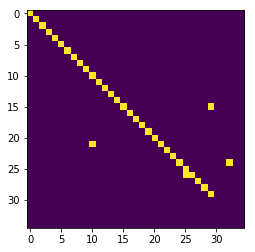

(35, 35)


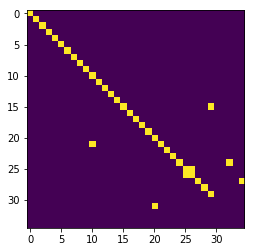

(35, 35)


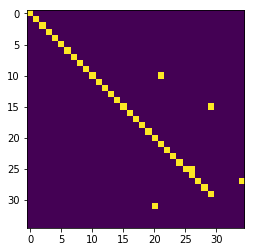

(35, 35)


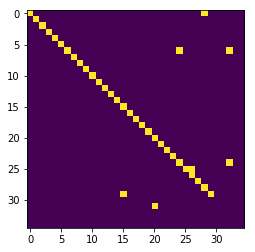

In [10]:
for s in solutions:
    print(s[3].shape)
    plt.imshow(s[3])
    plt.show()

### 2. Limit e_max (inlier fraction: 30/35)

In [16]:
from Stereo import * 

N = 30
s = Stereo(n = N)

# Set up two views of 30 points with rotation only
# s.transformCamera(x=a, y=b, z=c, roll=r, pitch=p, yaw=y)
rpy = (0.2,-0.1,0.1)

pts1 = s.transformCamera(False, 0,0,0,0,0,0)
pts2 = s.transformCamera(False, 0,0,0,*rpy)

# Outliers
n_out = 5
pts1 = np.concatenate((pts1, np.random.uniform(-1, 1, (n_out,2))), axis = 0)
pts2 = np.concatenate((pts2, np.random.uniform(-1, 1, (n_out,2))), axis = 0)

# Increase N to include outlier count
N += n_out

In [17]:
0.8*N

28.0

In [18]:
from bnb import * 
from math import pi, sqrt

%matplotlib inline
import matplotlib.pyplot as plt

import time 
start = time.time()

# Set up pts1 and pts2 as 3d vectors
pts2_ones = np.ones((N,3))
pts2_ones[:,:-1] = pts2
pts1_ones = np.ones((N,3))
pts1_ones[:,:-1] = pts1

# Prepare capacity matrix (parts common to all cases)
n_C = 1+N+N+1 
C = np.zeros((n_C, n_C))
C[0        , 1:N+1] = 1
C[N+1:N+N+1,    -1] = 1

e_max = 0
e_max_limit = 0.8 * N
delta = 1/32 * pi
# delta = 1/64 * pi # small delta
centres, sigma = subdivide(0, 0, 0, pi)

# Process blocks and subblocks in a queue
i = 0
queue = []
for c in centres: 
    queue.append((c[None, :], sigma, N))

# Store solutions
solutions = []

# For each block, given its centre and sigma, find its score
while i < len(queue): 
    
    # Get block from queue
    cen = queue[i][0]
    sigma = queue[i][1]
                 
    # Convert centre to R matrix, find pairwise angles between R(pts2) and pts1
    R = aa2mat(cen)
    Rp = np.dot(R, pts2_ones.T).T
    
    Rp_mag = np.linalg.norm(Rp, axis = 1, keepdims = True)
    q_mag  = np.linalg.norm(pts1_ones, axis = 1, keepdims = True)
    divisor = np.dot(Rp_mag, q_mag.T)
    
    cos_angle = np.dot(Rp, pts1_ones.T)/divisor
    angles = np.abs(np.arccos(cos_angle))
    
    print(f"\nIteration {i}   sigma: {sigma/pi} pi e_max = {e_max}")
    
    # Compute max cardinality at sqrt(3) sigma cutoff
    cutoff = sqrt(3) * sigma
    edges = angles < cutoff
    C[1:N+1, N+1:N+N+1] = np.where(edges, 1, 0)
    m = MaxFlow(C, 0, N+N+1)
    print(f"From MaxFlow, max cardinality: {m}")
    
    # Compute a running e_max with a tighter cutoff
    edges_tight = angles < delta
    C[1:N+1, N+1:N+N+1] = np.where(edges_tight, 1, 0)
    potential_max = MaxFlow(C, 0, N+N+1)
    print(f"potential_max: {potential_max}")
    
    if potential_max > e_max:
        print(f"Replaced e_max {e_max} with {potential_max}")
        e_max = min(potential_max, e_max_limit)
        
        # Updated e_max, so check queue for discardable blocks (parent_max lower than e_max)
        for j in range(len(queue)-1, i, -1):
            if queue[j][2] < e_max:
                queue.pop(j)
                print(f"Discarded {j}!")
        
    # Discard if m is lower than e_max, else continue subdividing
    # If cutoff <= delta, stop
    if m >= e_max:
        if cutoff > delta: 
            print("Continue!")
            centres, sigma = subdivide(*cen[0], sigma)
            for c in centres: 
                queue.append((c[None, :], sigma, m))
        else:
            print(f"Solution at delta resolution: {cen[0]}")
            solutions.append((cen, sigma, m, edges))
    else: 
        print("Discard!")
    
    i += 1
    
    
end = time.time()
print()
print(f"Total time: {end-start} seconds\n")

for s in solutions:
    print(f"centre: {s[0]} sigma: {s[1]}, max: {s[2]}\n")


Iteration 0   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 1   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 2   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 3   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 4   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 5   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 6   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 7   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 35.0
potential_max: 0.0
Continue!

Iteration 8   sigma: 0.25 pi e_max = 0
From MaxFlow, max cardinality: 21.0
potential_max: 0.0
Continue!

Iteration 9   sigma: 0.25 pi e_max = 0
From MaxFlow, max cardi

From MaxFlow, max cardinality: 20.0
potential_max: 0.0
Continue!

Iteration 70   sigma: 0.25 pi e_max = 9.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 71   sigma: 0.25 pi e_max = 9.0
From MaxFlow, max cardinality: 19.0
potential_max: 0.0
Continue!

Iteration 72   sigma: 0.125 pi e_max = 9.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Continue!

Iteration 73   sigma: 0.125 pi e_max = 9.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 74   sigma: 0.125 pi e_max = 9.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 75   sigma: 0.125 pi e_max = 9.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 76   sigma: 0.125 pi e_max = 9.0
From MaxFlow, max cardinality: 7.0
potential_max: 1.0
Discard!

Iteration 77   sigma: 0.125 pi e_max = 9.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 78   sigma: 0.125 pi e_max = 9.0
From MaxFlow, max cardinality: 7.

potential_max: 10.0
Continue!

Iteration 143   sigma: 0.125 pi e_max = 10.0
From MaxFlow, max cardinality: 33.0
potential_max: 14.0
Replaced e_max 10.0 with 14.0
Discarded 631!
Discarded 630!
Discarded 629!
Discarded 628!
Discarded 627!
Discarded 626!
Discarded 625!
Discarded 624!
Discarded 591!
Discarded 590!
Discarded 589!
Discarded 588!
Discarded 587!
Discarded 586!
Discarded 585!
Discarded 584!
Discarded 567!
Discarded 566!
Discarded 565!
Discarded 564!
Discarded 563!
Discarded 562!
Discarded 561!
Discarded 560!
Discarded 559!
Discarded 558!
Discarded 557!
Discarded 556!
Discarded 555!
Discarded 554!
Discarded 553!
Discarded 552!
Discarded 551!
Discarded 550!
Discarded 549!
Discarded 548!
Discarded 547!
Discarded 546!
Discarded 545!
Discarded 544!
Discarded 543!
Discarded 542!
Discarded 541!
Discarded 540!
Discarded 539!
Discarded 538!
Discarded 537!
Discarded 536!
Discarded 511!
Discarded 510!
Discarded 509!
Discarded 508!
Discarded 507!
Discarded 506!
Discarded 505!
Discarded 504

From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 203   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 16.0
potential_max: 2.0
Continue!

Iteration 204   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 205   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 9.0
potential_max: 0.0
Discard!

Iteration 206   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 207   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Discard!

Iteration 208   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 13.0
potential_max: 1.0
Discard!

Iteration 209   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 18.0
potential_max: 1.0
Continue!

Iteration 210   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 211   sigma: 0.125 pi e_max = 14.0
From MaxFlow, 


Iteration 280   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 12.0
potential_max: 2.0
Discard!

Iteration 281   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Discard!

Iteration 282   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 34.0
potential_max: 12.0
Continue!

Iteration 283   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 33.0
potential_max: 9.0
Continue!

Iteration 284   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 285   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 286   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 12.0
potential_max: 1.0
Discard!

Iteration 287   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 14.0
potential_max: 2.0
Continue!

Iteration 288   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 16.0
potential_max: 3.0
Continue!

Iterat

From MaxFlow, max cardinality: 12.0
potential_max: 0.0
Discard!

Iteration 357   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 13.0
potential_max: 0.0
Discard!

Iteration 358   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 359   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 360   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 32.0
potential_max: 8.0
Continue!

Iteration 361   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 35.0
potential_max: 11.0
Continue!

Iteration 362   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 18.0
potential_max: 2.0
Continue!

Iteration 363   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 22.0
potential_max: 4.0
Continue!

Iteration 364   sigma: 0.125 pi e_max = 14.0
From MaxFlow, max cardinality: 16.0
potential_max: 4.0
Continue!

Iteration 365   sigma: 0.125 pi e_max = 14.0
From M

From MaxFlow, max cardinality: 19.0
potential_max: 7.0
Continue!

Iteration 433   sigma: 0.0625 pi e_max = 14.0
From MaxFlow, max cardinality: 18.0
potential_max: 7.0
Continue!

Iteration 434   sigma: 0.0625 pi e_max = 14.0
From MaxFlow, max cardinality: 23.0
potential_max: 10.0
Continue!

Iteration 435   sigma: 0.0625 pi e_max = 14.0
From MaxFlow, max cardinality: 21.0
potential_max: 7.0
Continue!

Iteration 436   sigma: 0.0625 pi e_max = 14.0
From MaxFlow, max cardinality: 24.0
potential_max: 9.0
Continue!

Iteration 437   sigma: 0.0625 pi e_max = 14.0
From MaxFlow, max cardinality: 23.0
potential_max: 11.0
Continue!

Iteration 438   sigma: 0.0625 pi e_max = 14.0
From MaxFlow, max cardinality: 30.0
potential_max: 12.0
Continue!

Iteration 439   sigma: 0.0625 pi e_max = 14.0
From MaxFlow, max cardinality: 28.0
potential_max: 11.0
Continue!

Iteration 440   sigma: 0.0625 pi e_max = 14.0
From MaxFlow, max cardinality: 17.0
potential_max: 4.0
Continue!

Iteration 441   sigma: 0.0625 pi e

From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 486   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 7.0
potential_max: 2.0
Discard!

Iteration 487   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 488   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 489   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 490   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 491   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 7.0
potential_max: 1.0
Discard!

Iteration 492   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 493   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 4.0
potential_max: 2.0
Discard!

Iteration 494   sigma: 0.0625 pi e_max = 16.0
From MaxF

From MaxFlow, max cardinality: 20.0
potential_max: 6.0
Continue!

Iteration 533   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 22.0
potential_max: 9.0
Continue!

Iteration 534   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 31.0
potential_max: 14.0
Continue!

Iteration 535   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 32.0
potential_max: 15.0
Continue!

Iteration 536   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 7.0
potential_max: 2.0
Discard!

Iteration 537   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 4.0
Discard!

Iteration 538   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 11.0
potential_max: 3.0
Discard!

Iteration 539   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 5.0
Discard!

Iteration 540   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 541   sigma: 0.0625 pi e_max = 1

From MaxFlow, max cardinality: 23.0
potential_max: 8.0
Continue!

Iteration 608   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 18.0
potential_max: 9.0
Continue!

Iteration 609   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 19.0
potential_max: 10.0
Continue!

Iteration 610   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 13.0
potential_max: 3.0
Discard!

Iteration 611   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 3.0
Discard!

Iteration 612   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 30.0
potential_max: 14.0
Continue!

Iteration 613   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 30.0
potential_max: 13.0
Continue!

Iteration 614   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 24.0
potential_max: 8.0
Continue!

Iteration 615   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 10.0
Continue!

Iteration 616   sigma: 0.0625 pi e_m

From MaxFlow, max cardinality: 7.0
potential_max: 1.0
Discard!

Iteration 683   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 684   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 19.0
potential_max: 6.0
Continue!

Iteration 685   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 20.0
potential_max: 8.0
Continue!

Iteration 686   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 687   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 17.0
potential_max: 3.0
Discard!

Iteration 688   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 689   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 8.0
potential_max: 1.0
Discard!

Iteration 690   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 691   sigma: 0.0625 pi e_max = 18.0
Fro

From MaxFlow, max cardinality: 13.0
potential_max: 5.0
Discard!

Iteration 759   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 760   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 11.0
potential_max: 4.0
Discard!

Iteration 761   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 762   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 13.0
potential_max: 5.0
Discard!

Iteration 763   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 764   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 765   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 766   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 767   sigma: 0.0625 pi e_max = 18.0
From M

From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Discard!

Iteration 834   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 2.0
Discard!

Iteration 835   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 836   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 837   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 5.0
potential_max: 3.0
Discard!

Iteration 838   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 839   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 6.0
potential_max: 3.0
Discard!

Iteration 840   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 33.0
potential_max: 15.0
Continue!

Iteration 841   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 32.0
potential_max: 16.0
Continue!

Iteration 842   sigma: 0.0625 pi e_max = 18.0
Fr

From MaxFlow, max cardinality: 21.0
potential_max: 7.0
Continue!

Iteration 909   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 20.0
potential_max: 6.0
Continue!

Iteration 910   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Discard!

Iteration 911   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 2.0
Discard!

Iteration 912   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 913   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 914   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 4.0
potential_max: 1.0
Discard!

Iteration 915   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 2.0
potential_max: 1.0
Discard!

Iteration 916   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 2.0
Discard!

Iteration 917   sigma: 0.0625 pi e_max = 18.0
F

From MaxFlow, max cardinality: 8.0
potential_max: 2.0
Discard!

Iteration 983   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 8.0
potential_max: 4.0
Discard!

Iteration 984   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 13.0
potential_max: 7.0
Discard!

Iteration 985   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 10.0
potential_max: 9.0
Discard!

Iteration 986   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 11.0
potential_max: 8.0
Discard!

Iteration 987   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 8.0
Discard!

Iteration 988   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 9.0
Discard!

Iteration 989   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 14.0
potential_max: 9.0
Discard!

Iteration 990   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 9.0
Discard!

Iteration 991   sigma: 0.03125 pi e_max = 

potential_max: 7.0
Discard!

Iteration 1057   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 4.0
Discard!

Iteration 1058   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 14.0
potential_max: 10.0
Discard!

Iteration 1059   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 13.0
potential_max: 8.0
Discard!

Iteration 1060   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 11.0
potential_max: 5.0
Discard!

Iteration 1061   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 1062   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 17.0
potential_max: 6.0
Discard!

Iteration 1063   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 16.0
potential_max: 8.0
Discard!

Iteration 1064   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 18.0
potential_max: 10.0
Continue!

Iteration 1065   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, ma

From MaxFlow, max cardinality: 14.0
potential_max: 7.0
Discard!

Iteration 1130   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 19.0
potential_max: 11.0
Continue!

Iteration 1131   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 20.0
potential_max: 12.0
Continue!

Iteration 1132   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 18.0
potential_max: 12.0
Continue!

Iteration 1133   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 19.0
potential_max: 11.0
Continue!

Iteration 1134   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 17.0
Continue!

Iteration 1135   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 25.0
potential_max: 16.0
Continue!

Iteration 1136   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 10.0
potential_max: 7.0
Discard!

Iteration 1137   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 10.0
potential_max: 6.0
Discard!

Iteration 1138   si

From MaxFlow, max cardinality: 18.0
potential_max: 14.0
Continue!

Iteration 1204   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 11.0
potential_max: 7.0
Discard!

Iteration 1205   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 1206   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 16.0
potential_max: 12.0
Discard!

Iteration 1207   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 17.0
potential_max: 13.0
Discard!

Iteration 1208   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 19.0
potential_max: 13.0
Continue!

Iteration 1209   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 21.0
potential_max: 15.0
Continue!

Iteration 1210   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 14.0
Continue!

Iteration 1211   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 25.0
potential_max: 12.0
Continue!

Iteration 1212   si

From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 1277   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 1278   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 8.0
Discard!

Iteration 1279   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 10.0
Discard!

Iteration 1280   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 1281   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 8.0
Discard!

Iteration 1282   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 18.0
potential_max: 11.0
Continue!

Iteration 1283   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 20.0
potential_max: 11.0
Continue!

Iteration 1284   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 14.0
potential_max: 9.0
Discard!

Iteration 1285   sigma: 0.

From MaxFlow, max cardinality: 20.0
potential_max: 13.0
Continue!

Iteration 1351   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 21.0
potential_max: 12.0
Continue!

Iteration 1352   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 11.0
Continue!

Iteration 1353   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 13.0
Continue!

Iteration 1354   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 15.0
Continue!

Iteration 1355   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 22.0
potential_max: 15.0
Continue!

Iteration 1356   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 13.0
Continue!

Iteration 1357   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 12.0
Continue!

Iteration 1358   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 14.0
Continue!

Iteration 135

From MaxFlow, max cardinality: 19.0
potential_max: 13.0
Continue!

Iteration 1425   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 24.0
potential_max: 11.0
Continue!

Iteration 1426   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 13.0
Continue!

Iteration 1427   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 25.0
potential_max: 14.0
Continue!

Iteration 1428   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 24.0
potential_max: 15.0
Continue!

Iteration 1429   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 25.0
potential_max: 16.0
Continue!

Iteration 1430   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 24.0
potential_max: 18.0
Continue!

Iteration 1431   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 27.0
potential_max: 16.0
Continue!

Iteration 1432   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 5.0
Discard!

Iteration 1433 

From MaxFlow, max cardinality: 19.0
potential_max: 11.0
Continue!

Iteration 1499   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 17.0
potential_max: 11.0
Discard!

Iteration 1500   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 12.0
Continue!

Iteration 1501   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 25.0
potential_max: 9.0
Continue!

Iteration 1502   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 20.0
potential_max: 13.0
Continue!

Iteration 1503   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 21.0
potential_max: 13.0
Continue!

Iteration 1504   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 18.0
potential_max: 12.0
Continue!

Iteration 1505   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 18.0
potential_max: 11.0
Continue!

Iteration 1506   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 17.0
potential_max: 10.0
Discard!

Iteration 1507  

potential_max: 8.0
Discard!

Iteration 1571   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 1572   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 18.0
potential_max: 11.0
Continue!

Iteration 1573   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 18.0
potential_max: 11.0
Continue!

Iteration 1574   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 8.0
Discard!

Iteration 1575   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 9.0
Discard!

Iteration 1576   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 16.0
potential_max: 10.0
Discard!

Iteration 1577   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 16.0
potential_max: 10.0
Discard!

Iteration 1578   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 1579   sigma: 0.03125 pi e_max = 18.0
From MaxFlow,

From MaxFlow, max cardinality: 15.0
potential_max: 8.0
Discard!

Iteration 1617   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 15.0
potential_max: 10.0
Discard!

Iteration 1618   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 10.0
potential_max: 7.0
Discard!

Iteration 1619   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 1620   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 18.0
potential_max: 10.0
Discard!

Iteration 1621   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 17.0
potential_max: 11.0
Discard!

Iteration 1622   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 13.0
potential_max: 9.0
Discard!

Iteration 1623   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 12.0
potential_max: 10.0
Discard!

Iteration 1624   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 16.0
potential_max: 10.0
Discard!

Iteration 1625   sigma: 0.

Discarded 1956!
Discarded 1955!
Discarded 1954!
Discarded 1953!
Discarded 1952!
Discarded 1951!
Discarded 1950!
Discarded 1949!
Discarded 1948!
Discarded 1947!
Discarded 1946!
Discarded 1945!
Discarded 1944!
Discarded 1943!
Discarded 1942!
Discarded 1941!
Discarded 1940!
Discarded 1939!
Discarded 1938!
Discarded 1937!
Discarded 1936!
Discarded 1919!
Discarded 1918!
Discarded 1917!
Discarded 1916!
Discarded 1915!
Discarded 1914!
Discarded 1913!
Discarded 1912!
Discarded 1911!
Discarded 1910!
Discarded 1909!
Discarded 1908!
Discarded 1907!
Discarded 1906!
Discarded 1905!
Discarded 1904!
Discarded 1887!
Discarded 1886!
Discarded 1885!
Discarded 1884!
Discarded 1883!
Discarded 1882!
Discarded 1881!
Discarded 1880!
Discarded 1879!
Discarded 1878!
Discarded 1877!
Discarded 1876!
Discarded 1875!
Discarded 1874!
Discarded 1873!
Discarded 1872!
Discarded 1855!
Discarded 1854!
Discarded 1853!
Discarded 1852!
Discarded 1851!
Discarded 1850!
Discarded 1849!
Discarded 1848!
Discarded 1847!
Discarde

potential_max: 10.0
Discard!

Iteration 1699   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 17.0
potential_max: 10.0
Discard!

Iteration 1700   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 22.0
potential_max: 15.0
Discard!

Iteration 1701   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 22.0
potential_max: 15.0
Discard!

Iteration 1702   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 19.0
potential_max: 14.0
Discard!

Iteration 1703   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 19.0
potential_max: 12.0
Discard!

Iteration 1704   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 22.0
potential_max: 14.0
Discard!

Iteration 1705   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 24.0
potential_max: 13.0
Discard!

Iteration 1706   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 19.0
potential_max: 13.0
Discard!

Iteration 1707   sigma: 0.03125 pi e_max = 28.0
From MaxFl

From MaxFlow, max cardinality: 20.0
potential_max: 14.0
Discard!

Iteration 1772   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 20.0
potential_max: 11.0
Discard!

Iteration 1773   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 21.0
potential_max: 11.0
Discard!

Iteration 1774   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 21.0
potential_max: 13.0
Discard!

Iteration 1775   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 20.0
potential_max: 14.0
Discard!

Iteration 1776   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 16.0
potential_max: 7.0
Discard!

Iteration 1777   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 16.0
potential_max: 5.0
Discard!

Iteration 1778   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 20.0
potential_max: 11.0
Discard!

Iteration 1779   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 23.0
potential_max: 10.0
Discard!

Iteration 1780   sigma: 

From MaxFlow, max cardinality: 24.0
potential_max: 17.0
Discard!

Iteration 1844   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 18.0
potential_max: 12.0
Discard!

Iteration 1845   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 17.0
potential_max: 11.0
Discard!

Iteration 1846   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 17.0
potential_max: 10.0
Discard!

Iteration 1847   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 17.0
potential_max: 10.0
Discard!

Iteration 1848   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 19.0
potential_max: 11.0
Discard!

Iteration 1849   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 23.0
potential_max: 12.0
Discard!

Iteration 1850   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 22.0
potential_max: 14.0
Discard!

Iteration 1851   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 21.0
potential_max: 13.0
Discard!

Iteration 1852   sigma


Iteration 1916   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 23.0
potential_max: 12.0
Discard!

Iteration 1917   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 24.0
potential_max: 17.0
Discard!

Iteration 1918   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 24.0
potential_max: 14.0
Discard!

Iteration 1919   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 23.0
potential_max: 15.0
Discard!

Iteration 1920   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 24.0
potential_max: 16.0
Discard!

Iteration 1921   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 24.0
potential_max: 15.0
Discard!

Iteration 1922   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 22.0
potential_max: 15.0
Discard!

Iteration 1923   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 24.0
potential_max: 13.0
Discard!

Iteration 1924   sigma: 0.03125 pi e_max = 28.0
From MaxFlow, max cardinality: 25.0
pot

potential_max: 14.0
Discard!

Iteration 1990   sigma: 0.015625 pi e_max = 28.0
From MaxFlow, max cardinality: 17.0
potential_max: 19.0
Discard!

Iteration 1991   sigma: 0.015625 pi e_max = 28.0
From MaxFlow, max cardinality: 15.0
potential_max: 18.0
Discard!

Iteration 1992   sigma: 0.015625 pi e_max = 28.0
From MaxFlow, max cardinality: 14.0
potential_max: 17.0
Discard!

Iteration 1993   sigma: 0.015625 pi e_max = 28.0
From MaxFlow, max cardinality: 17.0
potential_max: 18.0
Discard!

Iteration 1994   sigma: 0.015625 pi e_max = 28.0
From MaxFlow, max cardinality: 15.0
potential_max: 17.0
Discard!

Iteration 1995   sigma: 0.015625 pi e_max = 28.0
From MaxFlow, max cardinality: 15.0
potential_max: 18.0
Discard!

Iteration 1996   sigma: 0.015625 pi e_max = 28.0
From MaxFlow, max cardinality: 17.0
potential_max: 19.0
Discard!

Iteration 1997   sigma: 0.015625 pi e_max = 28.0
From MaxFlow, max cardinality: 18.0
potential_max: 23.0
Discard!

Iteration 1998   sigma: 0.015625 pi e_max = 28.0
F

In [19]:
from helpers import R2rpy, rpy2R

acc = np.array([[0.,0.,0.]])
for s in solutions:
    acc += s[0]
    R = aa2mat(s[0])
    print(f"centre in pi-ball: {s[0]}  sigma: {s[1]}")
    print(f"R: \n{R}")
    print(f"rpy: {R2rpy(R)}")
    print("--\n")
    
print(f"Average: {acc/len(solutions)}")
R = aa2mat(acc/len(solutions))
print(f"R: \n{R}")
print(f"rpy: {R2rpy(R)}")

centre in pi-ball: [[-0.14726216  0.04908739  0.14726216]]  sigma: 0.04908738521234052
R: 
[[ 0.98799804 -0.14974166  0.03791192]
 [ 0.14254048  0.97839647  0.14974166]
 [-0.05951546 -0.14254048  0.98799804]]
rpy: (0.14328336643572476, -0.14328336643572476, 0.05955064701849848)
--

centre in pi-ball: [[-0.04908739  0.04908739  0.14726216]]  sigma: 0.04908738521234052
R: 
[[ 0.98797873 -0.14781461  0.04526445]
 [ 0.14541035  0.98797873  0.05247721]
 [-0.05247721 -0.04526445  0.99759575]]
rpy: (0.1461305134503701, -0.04534243591789748, 0.0525013230715799)
--

centre in pi-ball: [[-0.14726216  0.04908739  0.24543693]]  sigma: 0.04908738521234052
R: 
[[ 0.9688951  -0.24559065  0.03045519]
 [ 0.2384126   0.95932436  0.15118269]
 [-0.06634546 -0.13921926  0.98803658]]
rpy: (0.24127310410619798, -0.13998340277604684, 0.06639422861165259)
--

centre in pi-ball: [[-0.14726216  0.14726216  0.24543693]]  sigma: 0.04908738521234052
R: 
[[ 0.95938975 -0.25197025  0.126816  ]
 [ 0.23047071  0.959389

In [20]:
# Ground truth
print(f"Ground truth: \n{rpy2R(*rpy)}")
print(f"{rpy}")

Ground truth: 
[[ 0.97517033 -0.20744485  0.07752075]
 [ 0.19767681  0.97319025  0.11757815]
 [-0.09983342 -0.09933467  0.99003329]]
(0.2, -0.1, 0.1)


(35, 35)


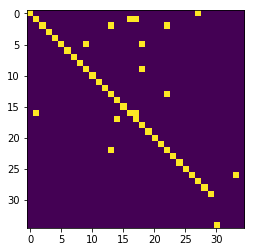

(35, 35)


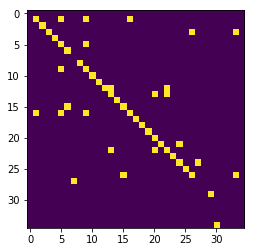

(35, 35)


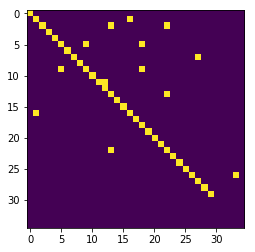

(35, 35)


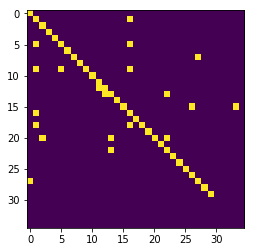

(35, 35)


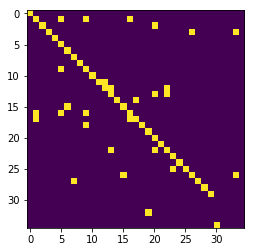

In [21]:
for s in solutions:
    print(s[3].shape)
    plt.imshow(s[3])
    plt.show()

### 3. Limit e_max (inlier fraction: 30/40)

In [35]:
from Stereo import * 

N = 30
s = Stereo(n = N)

# Set up two views of 30 points with rotation only
# s.transformCamera(x=a, y=b, z=c, roll=r, pitch=p, yaw=y)
rpy = (0.2,-0.1,0.1)

pts1 = s.transformCamera(False, 0,0,0,0,0,0)
pts2 = s.transformCamera(False, 0,0,0,*rpy)

# Outliers
n_out = 10
pts1 = np.concatenate((pts1, np.random.uniform(-1, 1, (n_out,2))), axis = 0)
pts2 = np.concatenate((pts2, np.random.uniform(-1, 1, (n_out,2))), axis = 0)

# Increase N to include outlier count
N += n_out

In [36]:
# Assume 60% inlier matches (20% noise)
0.75*N

30.0

In [37]:
from bnb import * 
from math import pi, sqrt

%matplotlib inline
import matplotlib.pyplot as plt

import time 
start = time.time()

# Set up pts1 and pts2 as 3d vectors
pts2_ones = np.ones((N,3))
pts2_ones[:,:-1] = pts2
pts1_ones = np.ones((N,3))
pts1_ones[:,:-1] = pts1

# Prepare capacity matrix (parts common to all cases)
n_C = 1+N+N+1 
C = np.zeros((n_C, n_C))
C[0        , 1:N+1] = 1
C[N+1:N+N+1,    -1] = 1

e_max = 0
e_max_limit = 0.6 * N
delta = 1/32 * pi
# delta = 1/64 * pi # small delta
centres, sigma = subdivide(0, 0, 0, pi)

# Process blocks and subblocks in a queue
i = 0
queue = []
for c in centres: 
    queue.append((c[None, :], sigma, N))

# Store solutions
solutions = []

# For each block, given its centre and sigma, find its score
while i < len(queue): 
    
    # Get block from queue
    cen = queue[i][0]
    sigma = queue[i][1]
                 
    # Convert centre to R matrix, find pairwise angles between R(pts2) and pts1
    R = aa2mat(cen)
    Rp = np.dot(R, pts2_ones.T).T
    
    Rp_mag = np.linalg.norm(Rp, axis = 1, keepdims = True)
    q_mag  = np.linalg.norm(pts1_ones, axis = 1, keepdims = True)
    divisor = np.dot(Rp_mag, q_mag.T)
    
    cos_angle = np.dot(Rp, pts1_ones.T)/divisor
    angles = np.abs(np.arccos(cos_angle))
    
    print(f"\nIteration {i}   sigma: {sigma/pi} pi e_max = {e_max}")
    
    # Compute max cardinality at sqrt(3) sigma cutoff
    cutoff = sqrt(3) * sigma
    edges = angles < cutoff
    C[1:N+1, N+1:N+N+1] = np.where(edges, 1, 0)
    m = MaxFlow(C, 0, N+N+1)
    print(f"From MaxFlow, max cardinality: {m}")
    
    # Compute a running e_max with a tighter cutoff
    edges_tight = angles < delta
    C[1:N+1, N+1:N+N+1] = np.where(edges_tight, 1, 0)
    potential_max = MaxFlow(C, 0, N+N+1)
    print(f"potential_max: {potential_max}")
    
    if potential_max > e_max:
        print(f"Replaced e_max {e_max} with {potential_max}")
        e_max = min(potential_max, e_max_limit)
        
        # Updated e_max, so check queue for discardable blocks (parent_max lower than e_max)
        for j in range(len(queue)-1, i, -1):
            if queue[j][2] < e_max:
                queue.pop(j)
                print(f"Discarded {j}!")
        
    # Discard if m is lower than e_max, else continue subdividing
    # If cutoff <= delta, stop
    if m >= e_max:
        if cutoff > delta: 
            print("Continue!")
            centres, sigma = subdivide(*cen[0], sigma)
            for c in centres: 
                queue.append((c[None, :], sigma, m))
        else:
            print(f"Solution at delta resolution: {cen[0]}")
            solutions.append((cen, sigma, m, edges))
    else: 
        print("Discard!")
    
    i += 1
    
    
end = time.time()
print()
print(f"Total time: {end-start} seconds\n")

for s in solutions:
    print(f"centre: {s[0]} sigma: {s[1]}, max: {s[2]}\n")


Iteration 0   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 40.0
potential_max: 0.0
Continue!

Iteration 1   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 40.0
potential_max: 0.0
Continue!

Iteration 2   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 40.0
potential_max: 0.0
Continue!

Iteration 3   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 40.0
potential_max: 0.0
Continue!

Iteration 4   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 40.0
potential_max: 0.0
Continue!

Iteration 5   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 40.0
potential_max: 0.0
Continue!

Iteration 6   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 40.0
potential_max: 0.0
Continue!

Iteration 7   sigma: 0.5 pi e_max = 0
From MaxFlow, max cardinality: 40.0
potential_max: 0.0
Continue!

Iteration 8   sigma: 0.25 pi e_max = 0
From MaxFlow, max cardinality: 26.0
potential_max: 0.0
Continue!

Iteration 9   sigma: 0.25 pi e_max = 0
From MaxFlow, max cardi

From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 76   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 11.0
potential_max: 0.0
Continue!

Iteration 77   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 78   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 8.0
potential_max: 0.0
Continue!

Iteration 79   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 80   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Continue!

Iteration 81   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 82   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 10.0
potential_max: 1.0
Continue!

Iteration 83   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 84   sigma: 0.125 pi e_max = 7.0
From MaxFlow, max cardinality: 

From MaxFlow, max cardinality: 9.0
potential_max: 0.0
Discard!

Iteration 135   sigma: 0.125 pi e_max = 11.0
From MaxFlow, max cardinality: 17.0
potential_max: 0.0
Continue!

Iteration 136   sigma: 0.125 pi e_max = 11.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 137   sigma: 0.125 pi e_max = 11.0
From MaxFlow, max cardinality: 16.0
potential_max: 1.0
Continue!

Iteration 138   sigma: 0.125 pi e_max = 11.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 139   sigma: 0.125 pi e_max = 11.0
From MaxFlow, max cardinality: 16.0
potential_max: 1.0
Continue!

Iteration 140   sigma: 0.125 pi e_max = 11.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 141   sigma: 0.125 pi e_max = 11.0
From MaxFlow, max cardinality: 15.0
potential_max: 2.0
Continue!

Iteration 142   sigma: 0.125 pi e_max = 11.0
From MaxFlow, max cardinality: 11.0
potential_max: 0.0
Continue!

Iteration 143   sigma: 0.125 pi e_max = 11.0
From MaxF

From MaxFlow, max cardinality: 15.0
potential_max: 0.0
Discard!

Iteration 193   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 8.0
potential_max: 0.0
Discard!

Iteration 194   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Discard!

Iteration 195   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 196   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 22.0
potential_max: 2.0
Continue!

Iteration 197   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 13.0
potential_max: 1.0
Discard!

Iteration 198   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 11.0
potential_max: 1.0
Discard!

Iteration 199   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 5.0
potential_max: 0.0
Discard!

Iteration 200   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 1.0
potential_max: 0.0
Discard!

Iteration 201   sigma: 0.125 pi e_max = 16.0
From MaxFlow, 

From MaxFlow, max cardinality: 20.0
potential_max: 3.0
Continue!

Iteration 269   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 8.0
potential_max: 0.0
Discard!

Iteration 270   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 16.0
potential_max: 1.0
Continue!

Iteration 271   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 272   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 14.0
potential_max: 1.0
Discard!

Iteration 273   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 274   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 15.0
potential_max: 1.0
Discard!

Iteration 275   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 6.0
potential_max: 0.0
Discard!

Iteration 276   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 13.0
potential_max: 0.0
Discard!

Iteration 277   sigma: 0.125 pi e_max = 16.0
From MaxFlow

potential_max: 2.0
Continue!

Iteration 345   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 346   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 14.0
potential_max: 0.0
Discard!

Iteration 347   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 348   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 11.0
potential_max: 1.0
Discard!

Iteration 349   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 350   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 11.0
potential_max: 1.0
Discard!

Iteration 351   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 3.0
potential_max: 0.0
Discard!

Iteration 352   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 13.0
potential_max: 0.0
Discard!

Iteration 353   sigma: 0.125 pi e_max = 16.0
From MaxFlow, max cardinality: 2.0
potential_max:

From MaxFlow, max cardinality: 11.0
potential_max: 5.0
Discard!

Iteration 421   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 422   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 20.0
potential_max: 6.0
Continue!

Iteration 423   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 15.0
potential_max: 5.0
Discard!

Iteration 424   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 425   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 426   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Discard!

Iteration 427   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 428   sigma: 0.0625 pi e_max = 16.0
From MaxFlow, max cardinality: 7.0
potential_max: 3.0
Discard!

Iteration 429   sigma: 0.0625 pi e_max = 16.0
From

From MaxFlow, max cardinality: 8.0
potential_max: 1.0
Discard!

Iteration 481   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 13.0
potential_max: 4.0
Discard!

Iteration 482   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 6.0
potential_max: 1.0
Discard!

Iteration 483   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Discard!

Iteration 484   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 485   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 11.0
potential_max: 3.0
Discard!

Iteration 486   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 4.0
potential_max: 1.0
Discard!

Iteration 487   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Discard!

Iteration 488   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 2.0
potential_max: 0.0
Discard!

Iteration 489   sigma: 0.0625 pi e_max = 17.0
From Max

From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 555   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Discard!

Iteration 556   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 13.0
potential_max: 3.0
Discard!

Iteration 557   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 16.0
potential_max: 4.0
Discard!

Iteration 558   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 15.0
potential_max: 8.0
Discard!

Iteration 559   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 18.0
potential_max: 7.0
Continue!

Iteration 560   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 11.0
potential_max: 3.0
Discard!

Iteration 561   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 14.0
potential_max: 6.0
Discard!

Iteration 562   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 13.0
potential_max: 2.0
Discard!

Iteration 563   sigma: 0.0625 pi e_max = 17.0
Fr

From MaxFlow, max cardinality: 19.0
potential_max: 7.0
Continue!

Iteration 629   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 15.0
potential_max: 7.0
Discard!

Iteration 630   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 14.0
potential_max: 4.0
Discard!

Iteration 631   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 10.0
potential_max: 3.0
Discard!

Iteration 632   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 7.0
potential_max: 0.0
Discard!

Iteration 633   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 634   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 5.0
potential_max: 3.0
Discard!

Iteration 635   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 3.0
potential_max: 1.0
Discard!

Iteration 636   sigma: 0.0625 pi e_max = 17.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 637   sigma: 0.0625 pi e_max = 17.0
From

potential_max: 9.0
Continue!

Iteration 695   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 30.0
potential_max: 10.0
Continue!

Iteration 696   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 27.0
potential_max: 12.0
Continue!

Iteration 697   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 27.0
potential_max: 12.0
Continue!

Iteration 698   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 19.0
potential_max: 7.0
Continue!

Iteration 699   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 20.0
potential_max: 6.0
Continue!

Iteration 700   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 37.0
potential_max: 15.0
Continue!

Iteration 701   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 38.0
potential_max: 18.0
Continue!

Iteration 702   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 28.0
potential_max: 12.0
Continue!

Iteration 703   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max card

From MaxFlow, max cardinality: 7.0
potential_max: 1.0
Discard!

Iteration 771   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 7.0
potential_max: 2.0
Discard!

Iteration 772   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 17.0
potential_max: 8.0
Discard!

Iteration 773   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 19.0
potential_max: 7.0
Continue!

Iteration 774   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 6.0
Discard!

Iteration 775   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 16.0
potential_max: 6.0
Discard!

Iteration 776   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 12.0
potential_max: 3.0
Discard!

Iteration 777   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 14.0
potential_max: 7.0
Discard!

Iteration 778   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 779   sigma: 0.0625 pi e_max = 18.0
Fro

From MaxFlow, max cardinality: 11.0
potential_max: 3.0
Discard!

Iteration 845   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 846   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 6.0
Discard!

Iteration 847   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 10.0
potential_max: 2.0
Discard!

Iteration 848   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 16.0
potential_max: 6.0
Discard!

Iteration 849   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 17.0
potential_max: 6.0
Discard!

Iteration 850   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 29.0
potential_max: 9.0
Continue!

Iteration 851   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 27.0
potential_max: 13.0
Continue!

Iteration 852   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 853   sigma: 0.0625 pi e_max = 18.0

From MaxFlow, max cardinality: 24.0
potential_max: 6.0
Continue!

Iteration 920   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 25.0
potential_max: 10.0
Continue!

Iteration 921   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 28.0
potential_max: 14.0
Continue!

Iteration 922   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 36.0
potential_max: 16.0
Continue!

Iteration 923   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 38.0
potential_max: 16.0
Continue!

Iteration 924   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 6.0
Continue!

Iteration 925   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 26.0
potential_max: 9.0
Continue!

Iteration 926   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 26.0
potential_max: 7.0
Continue!

Iteration 927   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 28.0
potential_max: 11.0
Continue!

Iteration 928   sigma: 0.0625 pi 

From MaxFlow, max cardinality: 35.0
potential_max: 15.0
Continue!

Iteration 994   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 29.0
potential_max: 13.0
Continue!

Iteration 995   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 30.0
potential_max: 7.0
Continue!

Iteration 996   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 24.0
potential_max: 10.0
Continue!

Iteration 997   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 21.0
potential_max: 5.0
Continue!

Iteration 998   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 8.0
Continue!

Iteration 999   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 20.0
potential_max: 8.0
Continue!

Iteration 1000   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 26.0
potential_max: 11.0
Continue!

Iteration 1001   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 22.0
potential_max: 8.0
Continue!

Iteration 1002   sigma: 0.0625 p

From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 1067   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 5.0
potential_max: 1.0
Discard!

Iteration 1068   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 1069   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 1070   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 5.0
potential_max: 1.0
Discard!

Iteration 1071   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 4.0
potential_max: 0.0
Discard!

Iteration 1072   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 13.0
potential_max: 4.0
Discard!

Iteration 1073   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 9.0
potential_max: 1.0
Discard!

Iteration 1074   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 9.0
potential_max: 2.0
Discard!

Iteration 1075   sigma: 0.0625 pi e_max = 18.0

potential_max: 4.0
Discard!

Iteration 1141   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 14.0
potential_max: 4.0
Discard!

Iteration 1142   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 6.0
potential_max: 2.0
Discard!

Iteration 1143   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 11.0
potential_max: 3.0
Discard!

Iteration 1144   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 13.0
potential_max: 5.0
Discard!

Iteration 1145   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 6.0
Discard!

Iteration 1146   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 10.0
potential_max: 1.0
Discard!

Iteration 1147   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 11.0
potential_max: 3.0
Discard!

Iteration 1148   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality: 7.0
potential_max: 4.0
Discard!

Iteration 1149   sigma: 0.0625 pi e_max = 18.0
From MaxFlow, max cardinality:

From MaxFlow, max cardinality: 17.0
potential_max: 8.0
Discard!

Iteration 1216   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 8.0
Discard!

Iteration 1217   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 14.0
potential_max: 9.0
Discard!

Iteration 1218   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 18.0
potential_max: 7.0
Continue!

Iteration 1219   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 21.0
potential_max: 8.0
Continue!

Iteration 1220   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 21.0
potential_max: 8.0
Continue!

Iteration 1221   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 19.0
potential_max: 9.0
Continue!

Iteration 1222   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 25.0
potential_max: 13.0
Continue!

Iteration 1223   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 24.0
potential_max: 17.0
Continue!

Iteration 1224   sigma:

From MaxFlow, max cardinality: 20.0
potential_max: 10.0
Continue!

Iteration 1288   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 10.0
Discard!

Iteration 1289   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 14.0
potential_max: 8.0
Discard!

Iteration 1290   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 17.0
potential_max: 12.0
Discard!

Iteration 1291   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 17.0
potential_max: 9.0
Discard!

Iteration 1292   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 19.0
potential_max: 9.0
Continue!

Iteration 1293   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 19.0
potential_max: 8.0
Continue!

Iteration 1294   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 20.0
potential_max: 9.0
Continue!

Iteration 1295   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 19.0
potential_max: 10.0
Continue!

Iteration 1296   sigma

From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 1361   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 10.0
potential_max: 5.0
Discard!

Iteration 1362   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 14.0
potential_max: 9.0
Discard!

Iteration 1363   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 16.0
potential_max: 6.0
Discard!

Iteration 1364   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 9.0
potential_max: 8.0
Discard!

Iteration 1365   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 9.0
potential_max: 7.0
Discard!

Iteration 1366   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 16.0
potential_max: 11.0
Discard!

Iteration 1367   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 14.0
potential_max: 10.0
Discard!

Iteration 1368   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 21.0
potential_max: 11.0
Continue!

Iteration 1369   sigma: 0.031

From MaxFlow, max cardinality: 13.0
potential_max: 7.0
Discard!

Iteration 1434   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 16.0
potential_max: 11.0
Discard!

Iteration 1435   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 18.0
potential_max: 12.0
Continue!

Iteration 1436   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 14.0
potential_max: 6.0
Discard!

Iteration 1437   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 18.0
potential_max: 10.0
Continue!

Iteration 1438   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 23.0
potential_max: 10.0
Continue!

Iteration 1439   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 22.0
potential_max: 12.0
Continue!

Iteration 1440   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 13.0
potential_max: 9.0
Discard!

Iteration 1441   sigma: 0.03125 pi e_max = 18.0
From MaxFlow, max cardinality: 15.0
potential_max: 9.0
Discard!

Iteration 1442   sigma

From MaxFlow, max cardinality: 21.0
potential_max: 10.0
Continue!

Iteration 1477   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 21.0
potential_max: 9.0
Continue!

Iteration 1478   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 30.0
potential_max: 16.0
Continue!

Iteration 1479   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 28.0
potential_max: 12.0
Continue!

Iteration 1480   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 9.0
potential_max: 4.0
Discard!

Iteration 1481   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 9.0
potential_max: 5.0
Discard!

Iteration 1482   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 11.0
potential_max: 7.0
Discard!

Iteration 1483   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 12.0
potential_max: 9.0
Discard!

Iteration 1484   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 9.0
potential_max: 3.0
Discard!

Iteration 1485   sigma: 0.0

From MaxFlow, max cardinality: 16.0
potential_max: 10.0
Discard!

Iteration 1550   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 17.0
potential_max: 6.0
Discard!

Iteration 1551   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 16.0
potential_max: 8.0
Discard!

Iteration 1552   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 1553   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 14.0
potential_max: 6.0
Discard!

Iteration 1554   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 12.0
potential_max: 9.0
Discard!

Iteration 1555   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 13.0
potential_max: 10.0
Discard!

Iteration 1556   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 18.0
potential_max: 8.0
Discard!

Iteration 1557   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 14.0
potential_max: 7.0
Discard!

Iteration 1558   sigma: 0.031

From MaxFlow, max cardinality: 21.0
potential_max: 11.0
Continue!

Iteration 1623   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 20.0
potential_max: 12.0
Continue!

Iteration 1624   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 15.0
potential_max: 7.0
Discard!

Iteration 1625   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 17.0
potential_max: 10.0
Discard!

Iteration 1626   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 18.0
potential_max: 12.0
Discard!

Iteration 1627   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 18.0
potential_max: 9.0
Discard!

Iteration 1628   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 15.0
potential_max: 10.0
Discard!

Iteration 1629   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 18.0
potential_max: 10.0
Discard!

Iteration 1630   sigma: 0.03125 pi e_max = 19.0
From MaxFlow, max cardinality: 21.0
potential_max: 14.0
Continue!

Iteration 1631   sigm

From MaxFlow, max cardinality: 22.0
potential_max: 9.0
Continue!

Iteration 1649   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 22.0
potential_max: 13.0
Continue!

Iteration 1650   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 27.0
potential_max: 15.0
Continue!

Iteration 1651   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 24.0
potential_max: 16.0
Continue!

Iteration 1652   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 25.0
potential_max: 18.0
Continue!

Iteration 1653   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 25.0
potential_max: 17.0
Continue!

Iteration 1654   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 29.0
potential_max: 16.0
Continue!

Iteration 1655   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 29.0
potential_max: 17.0
Continue!

Iteration 1656   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 11.0
potential_max: 7.0
Discard!

Iteration 1657  

potential_max: 11.0
Discard!

Iteration 1722   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 16.0
potential_max: 7.0
Discard!

Iteration 1723   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 14.0
potential_max: 5.0
Discard!

Iteration 1724   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 17.0
potential_max: 8.0
Discard!

Iteration 1725   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 14.0
potential_max: 7.0
Discard!

Iteration 1726   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 22.0
potential_max: 8.0
Continue!

Iteration 1727   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 18.0
potential_max: 4.0
Discard!

Iteration 1728   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 13.0
potential_max: 9.0
Discard!

Iteration 1729   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 12.0
potential_max: 8.0
Discard!

Iteration 1730   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max

From MaxFlow, max cardinality: 24.0
potential_max: 13.0
Continue!

Iteration 1796   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 27.0
potential_max: 12.0
Continue!

Iteration 1797   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 22.0
potential_max: 14.0
Continue!

Iteration 1798   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 29.0
potential_max: 19.0
Continue!

Iteration 1799   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 27.0
potential_max: 13.0
Continue!

Iteration 1800   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 24.0
potential_max: 11.0
Continue!

Iteration 1801   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 26.0
potential_max: 12.0
Continue!

Iteration 1802   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 23.0
potential_max: 11.0
Continue!

Iteration 1803   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 19.0
potential_max: 9.0
Discard!

Iteration 1804 

potential_max: 10.0
Continue!

Iteration 1868   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 23.0
potential_max: 17.0
Continue!

Iteration 1869   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 22.0
potential_max: 14.0
Continue!

Iteration 1870   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 24.0
potential_max: 13.0
Continue!

Iteration 1871   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 21.0
potential_max: 13.0
Continue!

Iteration 1872   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 25.0
potential_max: 15.0
Continue!

Iteration 1873   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 24.0
potential_max: 11.0
Continue!

Iteration 1874   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 20.0
potential_max: 15.0
Continue!

Iteration 1875   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 20.0
potential_max: 15.0
Continue!

Iteration 1876   sigma: 0.03125 pi e_max = 20.0
F

From MaxFlow, max cardinality: 20.0
potential_max: 11.0
Continue!

Iteration 1941   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 17.0
potential_max: 9.0
Discard!

Iteration 1942   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 15.0
potential_max: 9.0
Discard!

Iteration 1943   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 1944   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 17.0
potential_max: 9.0
Discard!

Iteration 1945   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 16.0
potential_max: 9.0
Discard!

Iteration 1946   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 13.0
potential_max: 8.0
Discard!

Iteration 1947   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 10.0
potential_max: 4.0
Discard!

Iteration 1948   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 15.0
potential_max: 9.0
Discard!

Iteration 1949   sigma: 0.031

From MaxFlow, max cardinality: 22.0
potential_max: 12.0
Continue!

Iteration 2014   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 18.0
potential_max: 8.0
Discard!

Iteration 2015   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 16.0
potential_max: 11.0
Discard!

Iteration 2016   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 17.0
potential_max: 8.0
Discard!

Iteration 2017   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 15.0
potential_max: 9.0
Discard!

Iteration 2018   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 15.0
potential_max: 8.0
Discard!

Iteration 2019   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 15.0
potential_max: 7.0
Discard!

Iteration 2020   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 21.0
potential_max: 12.0
Continue!

Iteration 2021   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 25.0
potential_max: 11.0
Continue!

Iteration 2022   sigma: 

From MaxFlow, max cardinality: 18.0
potential_max: 11.0
Discard!

Iteration 2087   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 18.0
potential_max: 13.0
Discard!

Iteration 2088   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 11.0
potential_max: 6.0
Discard!

Iteration 2089   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 13.0
potential_max: 8.0
Discard!

Iteration 2090   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 7.0
potential_max: 3.0
Discard!

Iteration 2091   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 7.0
potential_max: 4.0
Discard!

Iteration 2092   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 17.0
potential_max: 7.0
Discard!

Iteration 2093   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 16.0
potential_max: 10.0
Discard!

Iteration 2094   sigma: 0.03125 pi e_max = 20.0
From MaxFlow, max cardinality: 8.0
potential_max: 3.0
Discard!

Iteration 2095   sigma: 0.03125

From MaxFlow, max cardinality: 34.0
potential_max: 33.0
Replaced e_max 24.0 with 33.0
Continue!

Iteration 2102   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 28.0
potential_max: 17.0
Continue!

Iteration 2103   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 25.0
potential_max: 14.0
Continue!

Iteration 2104   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 25.0
potential_max: 13.0
Continue!

Iteration 2105   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 26.0
potential_max: 15.0
Continue!

Iteration 2106   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 21.0
potential_max: 15.0
Discard!

Iteration 2107   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 22.0
potential_max: 14.0
Discard!

Iteration 2108   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 33.0
potential_max: 21.0
Continue!

Iteration 2109   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 29.0
potential_max: 1

potential_max: 15.0
Continue!

Iteration 2174   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 24.0
potential_max: 12.0
Continue!

Iteration 2175   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 24.0
potential_max: 11.0
Continue!

Iteration 2176   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 25.0
potential_max: 14.0
Continue!

Iteration 2177   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 23.0
potential_max: 12.0
Discard!

Iteration 2178   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 22.0
potential_max: 11.0
Discard!

Iteration 2179   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 20.0
potential_max: 12.0
Discard!

Iteration 2180   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 27.0
potential_max: 14.0
Continue!

Iteration 2181   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 25.0
potential_max: 10.0
Continue!

Iteration 2182   sigma: 0.03125 pi e_max = 24.0
From


Iteration 2246   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 9.0
Discard!

Iteration 2247   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 7.0
Discard!

Iteration 2248   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 8.0
Discard!

Iteration 2249   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 2250   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 11.0
Discard!

Iteration 2251   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 18.0
potential_max: 11.0
Discard!

Iteration 2252   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 9.0
Discard!

Iteration 2253   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 16.0
potential_max: 6.0
Discard!

Iteration 2254   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential

From MaxFlow, max cardinality: 20.0
potential_max: 10.0
Discard!

Iteration 2319   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 21.0
potential_max: 13.0
Discard!

Iteration 2320   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 14.0
Discard!

Iteration 2321   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 18.0
potential_max: 13.0
Discard!

Iteration 2322   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 20.0
potential_max: 14.0
Discard!

Iteration 2323   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 22.0
potential_max: 15.0
Discard!

Iteration 2324   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 17.0
potential_max: 8.0
Discard!

Iteration 2325   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 8.0
Discard!

Iteration 2326   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 13.0
Discard!

Iteration 2327   sigma: 

potential_max: 8.0
Discard!

Iteration 2391   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 6.0
Discard!

Iteration 2392   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 9.0
Discard!

Iteration 2393   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 11.0
Discard!

Iteration 2394   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 12.0
Discard!

Iteration 2395   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 20.0
potential_max: 14.0
Discard!

Iteration 2396   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 10.0
Discard!

Iteration 2397   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 11.0
Discard!

Iteration 2398   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 6.0
Discard!

Iteration 2399   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, 

potential_max: 10.0
Continue!

Iteration 2464   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 25.0
potential_max: 15.0
Continue!

Iteration 2465   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 23.0
potential_max: 13.0
Discard!

Iteration 2466   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 25.0
potential_max: 13.0
Continue!

Iteration 2467   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 24.0
potential_max: 11.0
Continue!

Iteration 2468   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 26.0
potential_max: 13.0
Continue!

Iteration 2469   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 23.0
potential_max: 11.0
Discard!

Iteration 2470   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 25.0
potential_max: 13.0
Continue!

Iteration 2471   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 23.0
potential_max: 10.0
Discard!

Iteration 2472   sigma: 0.03125 pi e_max = 24.0
From

potential_max: 12.0
Discard!

Iteration 2536   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 26.0
potential_max: 14.0
Continue!

Iteration 2537   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 25.0
potential_max: 16.0
Continue!

Iteration 2538   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 28.0
potential_max: 16.0
Continue!

Iteration 2539   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 24.0
potential_max: 16.0
Continue!

Iteration 2540   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 23.0
potential_max: 15.0
Discard!

Iteration 2541   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 23.0
potential_max: 15.0
Discard!

Iteration 2542   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 24.0
potential_max: 11.0
Continue!

Iteration 2543   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 22.0
potential_max: 13.0
Discard!

Iteration 2544   sigma: 0.03125 pi e_max = 24.0
From 

potential_max: 14.0
Continue!

Iteration 2609   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 23.0
potential_max: 15.0
Discard!

Iteration 2610   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 12.0
Discard!

Iteration 2611   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 18.0
potential_max: 13.0
Discard!

Iteration 2612   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 20.0
potential_max: 12.0
Discard!

Iteration 2613   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 20.0
potential_max: 10.0
Discard!

Iteration 2614   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 18.0
potential_max: 9.0
Discard!

Iteration 2615   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 10.0
Discard!

Iteration 2616   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 20.0
potential_max: 10.0
Discard!

Iteration 2617   sigma: 0.03125 pi e_max = 24.0
From MaxFl

From MaxFlow, max cardinality: 26.0
potential_max: 13.0
Continue!

Iteration 2682   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 27.0
potential_max: 20.0
Continue!

Iteration 2683   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 27.0
potential_max: 16.0
Continue!

Iteration 2684   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 20.0
potential_max: 14.0
Discard!

Iteration 2685   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 21.0
potential_max: 9.0
Discard!

Iteration 2686   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 20.0
potential_max: 8.0
Discard!

Iteration 2687   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 10.0
Discard!

Iteration 2688   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 25.0
potential_max: 11.0
Continue!

Iteration 2689   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 23.0
potential_max: 17.0
Discard!

Iteration 2690   sig

From MaxFlow, max cardinality: 19.0
potential_max: 9.0
Discard!

Iteration 2755   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 16.0
potential_max: 8.0
Discard!

Iteration 2756   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 10.0
Discard!

Iteration 2757   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 11.0
Discard!

Iteration 2758   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 7.0
Discard!

Iteration 2759   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 6.0
Discard!

Iteration 2760   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 11.0
Discard!

Iteration 2761   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 11.0
Discard!

Iteration 2762   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 17.0
potential_max: 7.0
Discard!

Iteration 2763   sigma: 0.0

From MaxFlow, max cardinality: 15.0
potential_max: 7.0
Discard!

Iteration 2828   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 9.0
Discard!

Iteration 2829   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 20.0
potential_max: 11.0
Discard!

Iteration 2830   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 4.0
Discard!

Iteration 2831   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 4.0
Discard!

Iteration 2832   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 21.0
potential_max: 12.0
Discard!

Iteration 2833   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 25.0
potential_max: 17.0
Continue!

Iteration 2834   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 18.0
potential_max: 11.0
Discard!

Iteration 2835   sigma: 0.03125 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 8.0
Discard!

Iteration 2836   sigma: 0.

From MaxFlow, max cardinality: 15.0
potential_max: 17.0
Discard!

Iteration 2900   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 13.0
Discard!

Iteration 2901   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 16.0
Discard!

Iteration 2902   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 17.0
Discard!

Iteration 2903   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 17.0
Discard!

Iteration 2904   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 2905   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 2906   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 16.0
Discard!

Iteration 2907   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 16.0
Discard!

Iteration 2908

From MaxFlow, max cardinality: 12.0
potential_max: 16.0
Discard!

Iteration 2972   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 2973   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 16.0
Discard!

Iteration 2974   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 2975   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 16.0
potential_max: 16.0
Discard!

Iteration 2976   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 15.0
Discard!

Iteration 2977   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 2978   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 14.0
Discard!

Iteration 2979   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 15.0
Discard!

Iteration 2980

potential_max: 15.0
Discard!

Iteration 3044   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 14.0
Discard!

Iteration 3045   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 16.0
Discard!

Iteration 3046   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 3047   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 16.0
Discard!

Iteration 3048   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 12.0
Discard!

Iteration 3049   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 11.0
Discard!

Iteration 3050   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 3051   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 12.0
Discard!

Iteration 3052   sigma: 0.015625 pi e_max = 24.0
Fr

potential_max: 12.0
Discard!

Iteration 3118   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 12.0
Discard!

Iteration 3119   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 15.0
Discard!

Iteration 3120   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 14.0
Discard!

Iteration 3121   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 3122   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 3123   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 3124   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 12.0
Discard!

Iteration 3125   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 12.0
Discard!

Iteration 3126   sigma: 0.015625 pi e_max = 24.0
Fr

potential_max: 19.0
Discard!

Iteration 3190   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 16.0
potential_max: 18.0
Discard!

Iteration 3191   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 16.0
potential_max: 16.0
Discard!

Iteration 3192   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 12.0
Discard!

Iteration 3193   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 14.0
Discard!

Iteration 3194   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 3195   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 16.0
Discard!

Iteration 3196   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 17.0
Discard!

Iteration 3197   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 3198   sigma: 0.015625 pi e_max = 24.0
Fr

potential_max: 13.0
Discard!

Iteration 3262   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 3263   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 3264   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 11.0
Discard!

Iteration 3265   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 3266   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 3267   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 3268   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 15.0
Discard!

Iteration 3269   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 14.0
Discard!

Iteration 3270   sigma: 0.015625 pi e_max = 24.0
F

potential_max: 14.0
Discard!

Iteration 3336   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 15.0
Discard!

Iteration 3337   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 16.0
Discard!

Iteration 3338   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 16.0
Discard!

Iteration 3339   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 17.0
Discard!

Iteration 3340   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 12.0
Discard!

Iteration 3341   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 12.0
Discard!

Iteration 3342   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 14.0
Discard!

Iteration 3343   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 14.0
Discard!

Iteration 3344   sigma: 0.015625 pi e_max = 24.0
Fr

From MaxFlow, max cardinality: 6.0
potential_max: 9.0
Discard!

Iteration 3409   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 11.0
Discard!

Iteration 3410   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 11.0
Discard!

Iteration 3411   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 11.0
Discard!

Iteration 3412   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 10.0
Discard!

Iteration 3413   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 11.0
Discard!

Iteration 3414   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 11.0
Discard!

Iteration 3415   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 12.0
Discard!

Iteration 3416   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 12.0
Discard!

Iteration 3417   sigma

From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 3483   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 3484   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 3485   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 3486   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 3487   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 3488   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 11.0
Discard!

Iteration 3489   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 12.0
Discard!

Iteration 3490   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 10.0
Discard!

Iteration 3491

From MaxFlow, max cardinality: 12.0
potential_max: 14.0
Discard!

Iteration 3556   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 16.0
Discard!

Iteration 3557   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 19.0
Discard!

Iteration 3558   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 15.0
Discard!

Iteration 3559   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 14.0
Discard!

Iteration 3560   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 13.0
Discard!

Iteration 3561   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 12.0
Discard!

Iteration 3562   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 12.0
Discard!

Iteration 3563   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 12.0
Discard!

Iteration 3564  

potential_max: 16.0
Discard!

Iteration 3628   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 3629   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 16.0
Discard!

Iteration 3630   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 16.0
Discard!

Iteration 3631   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 18.0
potential_max: 20.0
Discard!

Iteration 3632   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 3633   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 3634   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 3635   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 16.0
potential_max: 17.0
Discard!

Iteration 3636   sigma: 0.015625 pi e_max = 24.0
F

From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 3702   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 13.0
Discard!

Iteration 3703   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 13.0
Discard!

Iteration 3704   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 11.0
Discard!

Iteration 3705   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 12.0
Discard!

Iteration 3706   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 11.0
Discard!

Iteration 3707   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 3708   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 3709   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 3710   s

potential_max: 14.0
Discard!

Iteration 3775   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 12.0
Discard!

Iteration 3776   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 14.0
Discard!

Iteration 3777   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 12.0
Discard!

Iteration 3778   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 14.0
Discard!

Iteration 3779   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 13.0
Discard!

Iteration 3780   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 13.0
Discard!

Iteration 3781   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 12.0
Discard!

Iteration 3782   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 3783   sigma: 0.015625 pi e_max = 24.0
Fr

From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 3848   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 16.0
Discard!

Iteration 3849   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 19.0
Discard!

Iteration 3850   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 13.0
Discard!

Iteration 3851   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 16.0
Discard!

Iteration 3852   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 17.0
Discard!

Iteration 3853   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 18.0
Discard!

Iteration 3854   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 16.0
potential_max: 17.0
Discard!

Iteration 3855   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 15.0
Discard!

Iteration 3856

potential_max: 13.0
Discard!

Iteration 3919   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 12.0
Discard!

Iteration 3920   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 15.0
Discard!

Iteration 3921   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 15.0
Discard!

Iteration 3922   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 19.0
Discard!

Iteration 3923   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 14.0
Discard!

Iteration 3924   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 12.0
Discard!

Iteration 3925   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 3926   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 14.0
Discard!

Iteration 3927   sigma: 0.015625 pi e_max = 24.0
Fr

potential_max: 19.0
Discard!

Iteration 3992   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 3993   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 14.0
Discard!

Iteration 3994   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 12.0
Discard!

Iteration 3995   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 12.0
Discard!

Iteration 3996   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 16.0
potential_max: 19.0
Discard!

Iteration 3997   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 15.0
Discard!

Iteration 3998   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 16.0
potential_max: 16.0
Discard!

Iteration 3999   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 16.0
Discard!

Iteration 4000   sigma: 0.015625 pi e_max = 24.0
F

potential_max: 13.0
Discard!

Iteration 4065   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 10.0
Discard!

Iteration 4066   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 11.0
Discard!

Iteration 4067   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 11.0
Discard!

Iteration 4068   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 4069   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 4070   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 11.0
Discard!

Iteration 4071   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 7.0
potential_max: 12.0
Discard!

Iteration 4072   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 13.0
Discard!

Iteration 4073   sigma: 0.015625 pi e_max = 24.0
From 

potential_max: 26.0
Replaced e_max 24.0 with 26.0
Discard!

Iteration 4129   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 19.0
potential_max: 20.0
Discard!

Iteration 4130   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 19.0
Discard!

Iteration 4131   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 4132   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 22.0
potential_max: 26.0
Replaced e_max 24.0 with 26.0
Discard!

Iteration 4133   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 16.0
potential_max: 20.0
Discard!

Iteration 4134   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 17.0
potential_max: 21.0
Discard!

Iteration 4135   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 16.0
Discard!

Iteration 4136   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 18.0



Iteration 4201   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 4202   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 12.0
Discard!

Iteration 4203   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 14.0
Discard!

Iteration 4204   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 4205   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 14.0
Discard!

Iteration 4206   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 4207   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 14.0
Discard!

Iteration 4208   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 11.0
Discard!

Iteration 4209   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality:

From MaxFlow, max cardinality: 14.0
potential_max: 16.0
Discard!

Iteration 4274   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 13.0
Discard!

Iteration 4275   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 4276   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 11.0
Discard!

Iteration 4277   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 14.0
Discard!

Iteration 4278   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 10.0
Discard!

Iteration 4279   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 12.0
Discard!

Iteration 4280   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 18.0
Discard!

Iteration 4281   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 16.0
Discard!

Iteration 4282  

potential_max: 13.0
Discard!

Iteration 4347   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 12.0
Discard!

Iteration 4348   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 4349   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 4350   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 4351   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 15.0
Discard!

Iteration 4352   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 14.0
Discard!

Iteration 4353   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 15.0
Discard!

Iteration 4354   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 11.0
Discard!

Iteration 4355   sigma: 0.015625 pi e_max = 24.0
Fro

From MaxFlow, max cardinality: 15.0
potential_max: 18.0
Discard!

Iteration 4419   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 16.0
Discard!

Iteration 4420   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 16.0
Discard!

Iteration 4421   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 15.0
Discard!

Iteration 4422   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 17.0
Discard!

Iteration 4423   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 14.0
Discard!

Iteration 4424   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 4425   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 13.0
Discard!

Iteration 4426   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 12.0
Discard!

Iteration 4427 

potential_max: 15.0
Discard!

Iteration 4491   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 17.0
Discard!

Iteration 4492   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 10.0
Discard!

Iteration 4493   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 10.0
Discard!

Iteration 4494   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 4495   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 4496   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 17.0
Discard!

Iteration 4497   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 17.0
Discard!

Iteration 4498   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 18.0
Discard!

Iteration 4499   sigma: 0.015625 pi e_max = 24.0
Fro

From MaxFlow, max cardinality: 9.0
potential_max: 11.0
Discard!

Iteration 4565   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 11.0
Discard!

Iteration 4566   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 11.0
Discard!

Iteration 4567   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 11.0
Discard!

Iteration 4568   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 4569   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 14.0
Discard!

Iteration 4570   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 4571   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 4572   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 14.0
Discard!

Iteration 4573  

potential_max: 13.0
Discard!

Iteration 4639   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 11.0
Discard!

Iteration 4640   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 11.0
Discard!

Iteration 4641   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 9.0
Discard!

Iteration 4642   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 10.0
Discard!

Iteration 4643   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 11.0
Discard!

Iteration 4644   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 11.0
Discard!

Iteration 4645   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 12.0
Discard!

Iteration 4646   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 12.0
Discard!

Iteration 4647   sigma: 0.015625 pi e_max = 24.0
From Max

From MaxFlow, max cardinality: 11.0
potential_max: 16.0
Discard!

Iteration 4711   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 17.0
Discard!

Iteration 4712   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 17.0
Discard!

Iteration 4713   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 16.0
Discard!

Iteration 4714   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 17.0
Discard!

Iteration 4715   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 4716   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 4717   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 12.0
Discard!

Iteration 4718   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 11.0
Discard!

Iteration 4719

From MaxFlow, max cardinality: 8.0
potential_max: 8.0
Discard!

Iteration 4784   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 11.0
Discard!

Iteration 4785   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 4786   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 13.0
Discard!

Iteration 4787   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 4788   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 11.0
Discard!

Iteration 4789   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 4790   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 13.0
Discard!

Iteration 4791   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 4792   si

potential_max: 16.0
Discard!

Iteration 4857   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 17.0
Discard!

Iteration 4858   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 14.0
Discard!

Iteration 4859   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 12.0
Discard!

Iteration 4860   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 16.0
Discard!

Iteration 4861   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 17.0
Discard!

Iteration 4862   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 14.0
Discard!

Iteration 4863   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 14.0
Discard!

Iteration 4864   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 4865   sigma: 0.015625 pi e_max = 24.0
F

potential_max: 14.0
Discard!

Iteration 4929   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 4930   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 11.0
Discard!

Iteration 4931   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 14.0
Discard!

Iteration 4932   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 16.0
Discard!

Iteration 4933   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 16.0
Discard!

Iteration 4934   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 11.0
Discard!

Iteration 4935   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 4936   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 16.0
Discard!

Iteration 4937   sigma: 0.015625 pi e_max = 24.0
Fro

potential_max: 18.0
Discard!

Iteration 5002   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 16.0
Discard!

Iteration 5003   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 17.0
Discard!

Iteration 5004   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 5005   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 15.0
Discard!

Iteration 5006   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 15.0
potential_max: 16.0
Discard!

Iteration 5007   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 18.0
Discard!

Iteration 5008   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 12.0
Discard!

Iteration 5009   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 10.0
Discard!

Iteration 5010   sigma: 0.015625 pi e_max = 24.0
F

From MaxFlow, max cardinality: 11.0
potential_max: 11.0
Discard!

Iteration 5074   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 7.0
potential_max: 8.0
Discard!

Iteration 5075   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 10.0
Discard!

Iteration 5076   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 9.0
potential_max: 13.0
Discard!

Iteration 5077   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 5078   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 7.0
potential_max: 8.0
Discard!

Iteration 5079   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 12.0
Discard!

Iteration 5080   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 14.0
Discard!

Iteration 5081   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 15.0
Discard!

Iteration 5082   sigm

From MaxFlow, max cardinality: 12.0
potential_max: 16.0
Discard!

Iteration 5147   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 17.0
Discard!

Iteration 5148   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 14.0
Discard!

Iteration 5149   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 8.0
potential_max: 10.0
Discard!

Iteration 5150   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 15.0
Discard!

Iteration 5151   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 5152   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 18.0
Discard!

Iteration 5153   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 13.0
potential_max: 16.0
Discard!

Iteration 5154   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 14.0
Discard!

Iteration 5155 

potential_max: 12.0
Discard!

Iteration 5221   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 12.0
Discard!

Iteration 5222   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 5223   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 10.0
potential_max: 13.0
Discard!

Iteration 5224   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 12.0
potential_max: 15.0
Discard!

Iteration 5225   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 16.0
potential_max: 16.0
Discard!

Iteration 5226   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 16.0
Discard!

Iteration 5227   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 14.0
potential_max: 16.0
Discard!

Iteration 5228   sigma: 0.015625 pi e_max = 24.0
From MaxFlow, max cardinality: 11.0
potential_max: 13.0
Discard!

Iteration 5229   sigma: 0.015625 pi e_max = 24.0
F

potential_max: 13.0
Discard!

Total time: 681.0766463279724 seconds

centre: [[-0.14726216  0.04908739  0.14726216]] sigma: 0.04908738521234052, max: 30.0

centre: [[-0.14726216  0.14726216  0.04908739]] sigma: 0.04908738521234052, max: 25.0

centre: [[-0.14726216  0.14726216  0.14726216]] sigma: 0.04908738521234052, max: 29.0

centre: [[-0.04908739  0.04908739  0.14726216]] sigma: 0.04908738521234052, max: 27.0

centre: [[-0.14726216  0.04908739  0.24543693]] sigma: 0.04908738521234052, max: 31.0

centre: [[-0.14726216  0.04908739  0.3436117 ]] sigma: 0.04908738521234052, max: 27.0

centre: [[-0.14726216  0.14726216  0.24543693]] sigma: 0.04908738521234052, max: 31.0

centre: [[-0.04908739  0.04908739  0.24543693]] sigma: 0.04908738521234052, max: 30.0

centre: [[-0.04908739  0.04908739  0.3436117 ]] sigma: 0.04908738521234052, max: 26.0

centre: [[-0.04908739  0.14726216  0.24543693]] sigma: 0.04908738521234052, max: 25.0



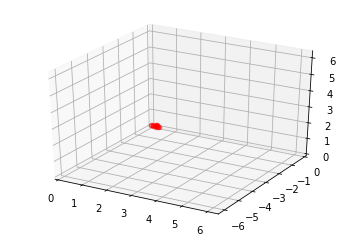

In [38]:
from helpers import R2rpy
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for s in solutions:
    ax.scatter(*R2rpy(aa2mat(s[0])), c='red', alpha=0.5)
    ax.set_xlim3d(0, 2*pi)
    ax.set_ylim3d(-2*pi, 0)
    ax.set_zlim3d(0, 2*pi)
    
plt.show()

In [39]:
from helpers import R2rpy

acc = np.array([[0.,0.,0.]])
for s in solutions:
    acc += s[0]
    R = aa2mat(s[0])
    print(f"centre in pi-ball: {s[0]}  sigma: {s[1]}")
    print(f"R: \n{R}")
    print(f"rpy: {R2rpy(R)}")
    print("--\n")
    
print(f"Average: {acc/len(solutions)}")
R = aa2mat(acc/len(solutions))
print(f"R: \n{R}")
print(f"rpy: {R2rpy(R)}")

centre in pi-ball: [[-0.14726216  0.04908739  0.14726216]]  sigma: 0.04908738521234052
R: 
[[ 0.98799804 -0.14974166  0.03791192]
 [ 0.14254048  0.97839647  0.14974166]
 [-0.05951546 -0.14254048  0.98799804]]
rpy: (0.14328336643572476, -0.14328336643572476, 0.05955064701849848)
--

centre in pi-ball: [[-0.14726216  0.14726216  0.04908739]]  sigma: 0.04908738521234052
R: 
[[ 0.98799804 -0.05951546  0.14254048]
 [ 0.03791192  0.98799804  0.14974166]
 [-0.14974166 -0.14254048  0.97839647]]
rpy: (0.03835365115100617, -0.14467004419135585, 0.1503069795756503)
--

centre in pi-ball: [[-0.14726216  0.14726216  0.14726216]]  sigma: 0.04908738521234052
R: 
[[ 0.97843118 -0.15645498  0.13488616]
 [ 0.13488616  0.97843118  0.15645498]
 [-0.15645498 -0.13488616  0.97843118]]
rpy: (0.1369960977247335, -0.1369960977247335, 0.15710040361261335)
--

centre in pi-ball: [[-0.04908739  0.04908739  0.14726216]]  sigma: 0.04908738521234052
R: 
[[ 0.98797873 -0.14781461  0.04526445]
 [ 0.14541035  0.9879787

In [20]:
# Ground truth
print(f"Ground truth: \n{rpy2R(*rpy)}")
print(f"{rpy}")

Ground truth: 
[[ 0.97517033 -0.20744485  0.07752075]
 [ 0.19767681  0.97319025  0.11757815]
 [-0.09983342 -0.09933467  0.99003329]]
(0.2, -0.1, 0.1)


(40, 40)


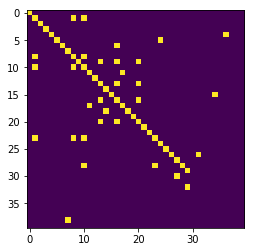

(40, 40)


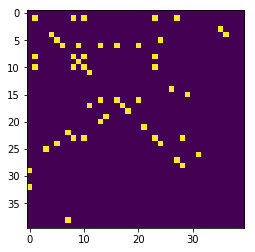

(40, 40)


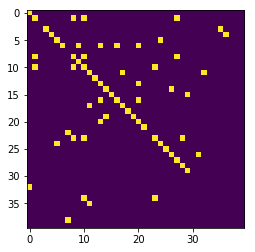

(40, 40)


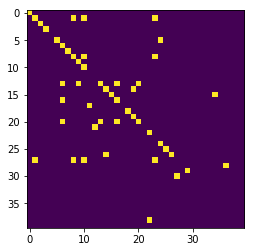

(40, 40)


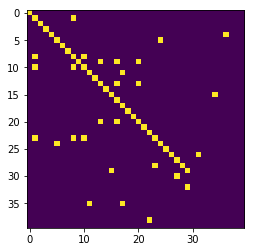

(40, 40)


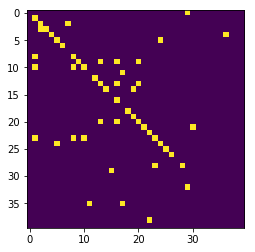

(40, 40)


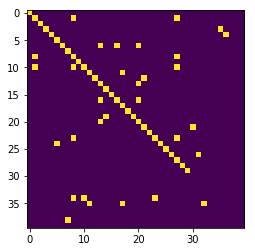

(40, 40)


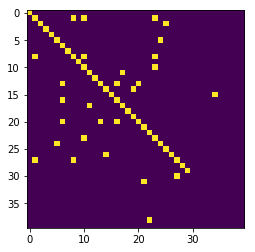

(40, 40)


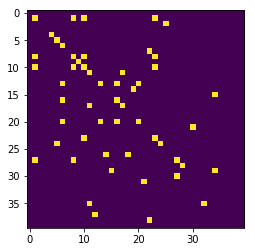

(40, 40)


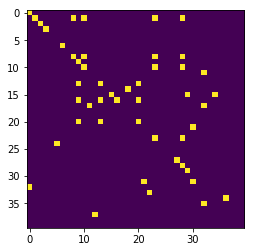

In [40]:
for s in solutions:
    print(s[3].shape)
    plt.imshow(s[3])
    plt.show()

In [42]:
len(solutions)

10